# Exploratory Modelling and Analysis of Vensim Cobalt Model

### First, import packages

In [1]:
from __future__ import (absolute_import, print_function, division,  unicode_literals)
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant, Policy, perform_experiments, ema_logging,
                           TimeSeriesOutcome, perform_experiments, save_results, load_results)
from ema_workbench.analysis import (feature_scoring)
from ema_workbench.analysis.pairs_plotting import (pairs_lines, pairs_scatter, pairs_density)
from ema_workbench.connectors.vensim import (VensimModel) #LookupUncertainty, VensimModel, VensimModelStructureInterface)
from ema_workbench.em_framework import CategoricalParameter
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis.plotting import lines, envelopes
from ema_workbench.analysis import clusterer, plotting, Density

import numpy as np
import seaborn as sns #; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt

from Figures import plot_lines_with_envelopes
from plotting_util import group_results, filter_scalar_outcomes,make_grid, make_legend
TIME_LABEL = 'Time'
from ema_workbench.analysis.plotting_util import prepare_data, COLOR_LIST, simple_kde, group_density,\
                                                 plot_envelope, simple_density, do_titles,\
                                                 do_ylabels, TIME
import ema_workbench.analysis.plotting_util as plt_util
from ema_workbench.analysis.plotting import group_by_envelopes, single_envelope, plot_lines_with_envelopes
from ema_workbench.analysis.pairs_plotting import pairs_scatter, pairs_density
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import (get_ex_feature_scores,
                                    RuleInductionType)

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\ProgramData\Anaconda3_32bits\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3_32bits\lib\site-packages\ema_workbench\connectors\__init__.py:27: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


In [2]:
import itertools
import copy
from copy import deepcopy

import numpy as np
import datetime
import math
import matplotlib.gridspec as gridspec

import scipy.stats.kde as kde
from matplotlib.colors import ColorConverter
from matplotlib.collections import PolyCollection, PathCollection
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from matplotlib.patches import ConnectionPatch
import matplotlib.font_manager as fm
import matplotlib as mpl

### Set WD

In [3]:
# wd = 'C:/Users/erika/Google Drive/EPA/Thesis/Model/'
wd = 'C:/Users/erika/Desktop/EMA_runs/'
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### Define model

In [152]:
Cobalt_model = VensimModel('Vensim', wd = wd, model_file=wd+'Cu_Ni_Co_13dec.vpm')

### Define uncertainties and outcomes

In [153]:
Cobalt_model.uncertainties = [
#     Switches
        CategoricalParameter('Switch opportunity cost fixed stock',(1,2),pff = True ),
        CategoricalParameter('Switch SSP', (1,2,3,4,5) ),
        CategoricalParameter('Switch carbon policy',(0,1) ),
        CategoricalParameter('Switch energy price growth scenario', (1,2,3) ),
        CategoricalParameter('Switch real price', (1,2)),
#     Assumptions metal stocks
        RealParameter('Percentage lost during artisanal mining',0.4 ,0.6 ),
#         RealParameter('Part artisanal mining from classified reserves',0.1 ,0.3 ),
#         RealParameter('Administration time',10 ,20 ),
#         RealParameter('Average time mining until refining',0.09 ,0.11 ),
#         RealParameter('Average time scrap to recycling',0.38 ,0.42 ),
#         RealParameter('Maximum recycling efficiency score',0.8 ,0.99 ),
#         RealParameter('Yearly increase recyclying efficiency score', 0.03, 0.07 ),
#         RealParameter('Recycling efficiency score in 2018', 0.4,0.6),
#         RealParameter('Percentage of primary scrap',0.25 ,0.4 ),
#         RealParameter('Average lifetime of metal in use',5 ,15 ),
        RealParameter('Collection rate metal products',0.4 ,0.8 ),
        RealParameter('Short forecasting period', 0.5,2 ),
#         CategoricalParameter('Delay order consumption forecast',(1,3,5) ),
        RealParameter('Minimum usage mining capacity', 0.7,0.9),
        RealParameter('Minimum usage smelting and refining capacity', 0.7,0.9),
#         RealParameter('Percentage lost during operations', 0.04, 0.08),
#     Assumptions industrial and artisanal mining capacity
        RealParameter('Mining usage investment cap',0 ,0.95 ),
#         CategoricalParameter('Delay order production capacity',(1,3,5) ),
#         RealParameter('Average permit term', 5 , 15 ),
        RealParameter('Smelter and refiner usage investment cap', 0, 0.95), 
        RealParameter('Percentage of profit from refined cobalt for artisanal miners', 0.04, 0.1),
        RealParameter('Productivity of artisanal mining', 800, 1600),
        RealParameter('Minimum cost of artisanal mining', 800, 1300),
        RealParameter('Maximum increase recovery rate', 0.05, 0.25),
#     Assumptions Demand
#         RealParameter('Ni per dollar GDP', 0.000004, 0.000008 ),
#         RealParameter('Co per dollar GDP', 0.000001, 0.0000015 ),
#         RealParameter('Cu per dollar GDP', 0.000025, 0.000035 ),
#         RealParameter('Period for long term effect on demand', 5,15),
#         RealParameter('Copper substitution threshold', 3,5),
#         RealParameter('Nickel substitution threshold', 5,9),
#         RealParameter('Cobalt substitution threshold', 5,7),
#         RealParameter('Long term substitution strength',0.1, 0.15),
#         RealParameter('Short term substitution strength', 0.02, 0.06),
#         RealParameter('Substitution strength battery compared to traditional', 0.01,0.05),
#     Assumptions Battery transition
#         RealParameter('Increase in demand stationary storage', 0.2 , 0.4),
#         RealParameter('Slowing of increase in demand stationary storage', 0.88 , 0.96),
#         RealParameter('Battery capacity PHEV', 8 , 17),
#         RealParameter('Battery capacity BEV', 20 , 40),
#         RealParameter('Number of cars per dollar GDP', 1.369e-006, 2.369e-006),
#         RealParameter('Battery capacity Ebus',150, 220 ),
#         RealParameter('Number of buses per person',0.001, 0.002),
#         RealParameter('Battery capacity Etruck', 60, 100),
#     Assumptions Economics
        RealParameter('Percentage cost on top of marginal cost', 0.05 , 0.25 ),
        RealParameter('Price elasticity long term', 0.1 , 0.25),
        RealParameter('Price elasticity short term', 0.02, 0.08),
#         RealParameter('Price amplifying factor', 0.5 , 3),
#         RealParameter('Cobalt taxes in DRC', 0.3, 0.8),
#         RealParameter('Marginal cost bottom price relationship copper', 0.01, 0.015),
#         RealParameter('Marginal cost bottom price relationship nickel', 0.08, 0.12),
#         RealParameter('Marginal cost bottom price relationship cobalt', 0.05,0.075),
#         RealParameter('Exponent copper price curve',-1.6, -1.4),
#         RealParameter('Exponent nickel price curve',-0.95, -0.85),
#         RealParameter('Exponent cobalt price curve',-1.3, -1.1),
#         RealParameter('Innovation in mining sector', 0.8 ,1 ),
#         RealParameter('Relation ore grade energy usage copper',-1.05,-0.95 ),
#         RealParameter('Relation ore grade energy usage nickel',-0.77, -0.67 ),
#         RealParameter('Relation ore grade energy usage cobalt',-3.1, -2.9 ),
#         RealParameter('Base energy usage copper', 0.075,0.085),
#         RealParameter('Base energy usage nickel', 0.09, 0.13),
#         RealParameter('Base energy usage cobalt', 0.09, 0.11),
#         RealParameter('Transport costs copper', 0.02, 0.06),
#         RealParameter('Transport costs nickel', 0.1, 0.3),
#         RealParameter('Transport costs cobalt', 0.1, 0.3),
#         RealParameter('Price averaging period', 0.1, 0.4),
        RealParameter('Power for oregrades', 0.38, 0.42 ),
#         RealParameter('Maximum increase production capacity', 0.1, 0.2),
#         RealParameter('Maximum decrease production capacity', 0.02, 0.05),
]
    
Cobalt_model.outcomes =  [
#     General
        TimeSeriesOutcome('TIME'),
        TimeSeriesOutcome('Total demand[Copper]'),
        TimeSeriesOutcome('Total demand[Nickel]'),
        TimeSeriesOutcome('Total demand[Cobalt]'),
        TimeSeriesOutcome('Marginal cost[Copper]'),
        TimeSeriesOutcome('Marginal cost[Nickel]'),
        TimeSeriesOutcome('Marginal cost[Cobalt]'),
#     Fixed Stock metrics
        TimeSeriesOutcome('R over P ratio[Copper]'),
        TimeSeriesOutcome('R over P ratio[Nickel]'),
        TimeSeriesOutcome('R over P ratio[Cobalt]'),
#         TimeSeriesOutcome('Exponential index of depletion[Copper]'),
#         TimeSeriesOutcome('Exponential index of depletion[Nickel]'),
        TimeSeriesOutcome('Exponential index of depletion[Cobalt]'),
#     Opportunity Cost metrics
        TimeSeriesOutcome('Real price[Copper]'),
        TimeSeriesOutcome('Real price[Nickel]'),
        TimeSeriesOutcome('Real price[Cobalt]'),
#     Relative parts types of mining
        TimeSeriesOutcome('Relative part artisanal mining[Cobalt]'),
        TimeSeriesOutcome('Artisanal ore trade[Cobalt]'),
        TimeSeriesOutcome('Industrial Ore mining[Copper]'),
        TimeSeriesOutcome('Industrial Ore mining[Nickel]'),
        TimeSeriesOutcome('Industrial Ore mining[Cobalt]'),
#         TimeSeriesOutcome('Relative part industrial mining[Copper]'),
#         TimeSeriesOutcome('Relative part industrial mining[Nickel]'),
        TimeSeriesOutcome('Relative part industrial mining[Cobalt]'),
#         TimeSeriesOutcome('Relative part recycled scrap[Copper]'),
#         TimeSeriesOutcome('Relative part recycled scrap[Nickel]'),
        TimeSeriesOutcome('Relative part recycled scrap[Cobalt]'),
#     Metal stocks
#         TimeSeriesOutcome('Resources[Copper]'),
#         TimeSeriesOutcome('Resources[Nickel]'),
        TimeSeriesOutcome('Resources[Cobalt]'),
#         TimeSeriesOutcome('Reserve base[Copper]'),
#         TimeSeriesOutcome('Reserve base[Nickel]'),
        TimeSeriesOutcome('Reserve base[Cobalt]'),
#         TimeSeriesOutcome('Recycling input rate[Copper]'),
#         TimeSeriesOutcome('Recycling input rate[Nickel]'),
        TimeSeriesOutcome('Recycling input rate[Cobalt]'),
#         TimeSeriesOutcome('Smelting and refining capacity utilisation rate[Copper]'),
#         TimeSeriesOutcome('Smelting and refining capacity utilisation rate[Nickel]'),
        TimeSeriesOutcome('Smelting and refining capacity utilisation rate[Cobalt]'),
        TimeSeriesOutcome('Recycling efficiency score'),
# #     Industrial and artisanal mining capacity
        TimeSeriesOutcome('Industrial mining capacity[Sed hosted Co]'),
#         TimeSeriesOutcome('Industrial mining capacity[Sed hosted]'),
        TimeSeriesOutcome('Industrial mining capacity[Ni laterite Co]'),
#         TimeSeriesOutcome('Industrial mining capacity[Ni laterite]'),
#         TimeSeriesOutcome('Industrial mining capacity[Porphyry Cu]'),
        TimeSeriesOutcome('Industrial mining capacity[Magm sulfide Co]'),
#         TimeSeriesOutcome('Industrial mining capacity[Magm sulfide]'),
        TimeSeriesOutcome('Industrial mining capacity metals[Copper]'),
        TimeSeriesOutcome('Industrial mining capacity metals[Nickel]'),
        TimeSeriesOutcome('Industrial mining capacity metals[Cobalt]'),
        TimeSeriesOutcome('Typical Co recovery rate[Sed hosted Co]'),
        TimeSeriesOutcome('Typical Co recovery rate[Ni laterite Co]'),
        TimeSeriesOutcome('Typical Co recovery rate[Magm sulfide Co]'),
#         TimeSeriesOutcome('Smelting and refining capacity[Copper]'),
#         TimeSeriesOutcome('Smelting and refining capacity[Nickel]'),
        TimeSeriesOutcome('Smelting and refining capacity[Cobalt]'),
        TimeSeriesOutcome('Population Katanga below poverty line'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Cobalt,Sed hosted Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Copper,Sed hosted Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Nickel,Ni laterite Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Cobalt,Ni laterite Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Copper,Magm sulfide Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Nickel,Magm sulfide Co]'),
        TimeSeriesOutcome('Percentage profit industrial mining capacity per metal[Cobalt,Magm sulfide Co]'),
    #     Demand
#         TimeSeriesOutcome('Total substitution[Copper]'),
#         TimeSeriesOutcome('Total substitution[Nickel]'),
        TimeSeriesOutcome('Total substitution[Cobalt]'),
#         TimeSeriesOutcome('Postponed demand[Copper]'), 
#         TimeSeriesOutcome('Postponed demand[Nickel]'),
#         TimeSeriesOutcome('Postponed demand[Cobalt]'),
# #     Battery transition
        TimeSeriesOutcome('Total battery capacity demand from cars'),
        TimeSeriesOutcome('Battery capacity demand from Ebuses'),
        TimeSeriesOutcome('Battery capacity demand from Etrucks'),
        TimeSeriesOutcome('New consumer electronics capacity'),
        TimeSeriesOutcome('Newly built stationary storage capacity'),
# #     Economics
#         TimeSeriesOutcome('Energy price'),
#         TimeSeriesOutcome('Energy costs mining[Copper]'),
#         TimeSeriesOutcome('Energy costs mining[Nickel]'),
        TimeSeriesOutcome('Energy costs mining[Cobalt]'),
        TimeSeriesOutcome('Energy usage mining[Cobalt]'),
#         TimeSeriesOutcome('Normalised profit forecast[Copper]'),
#         TimeSeriesOutcome('Normalised profit forecast[Nickel]'),
        TimeSeriesOutcome('Normalised profit forecast[Cobalt]'),
        TimeSeriesOutcome('Marge per lb[Cobalt]')
# #     SSPs
#         TimeSeriesOutcome('World population'),
#         TimeSeriesOutcome('Population growth'),
#         TimeSeriesOutcome('GDP per capita growth per year'),
#         TimeSeriesOutcome('World GDP growth per year'),
]

## Create, or load results

In [222]:
nr_experiments =15000
results_both_alloutcomes = perform_experiments([Cobalt_model],
                                  nr_experiments, uncertainty_sampling='pff')

In [30]:
save_results(results_both_alloutcomes, r'C:/Users/erika/Desktop/EMA_runs/500runs_pff2_alloutcomes.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\erika\Desktop\EMA_runs\500runs_pff2_alloutcomes.tar.gz


In [227]:
# results_both_alloutcomes = load_results('C:/Users/erika/Desktop/EMA_runs/30000runs_pff2_alloutcomes.tar.gz')

In [155]:
exp_b, out_b= results_both_alloutcomes

## Defining some functions

In [15]:
def clustering (paradigm, column, nr_of_clusters):
    if paradigm == 'fs':
        dataset=out_fs
        expdata=exp_fs
    elif paradigm == 'oc':
        dataset=out_oc
        expdata=exp_oc
    else:
        dataset = out_b
        expdata = exp_b
    data = dataset[column]
    distances = clusterer.calculate_cid(data)

    # calcuate distances
    distances = clusterer.calculate_cid(data)

    # do agglomerative clustering on the distances
    clusters = clusterer.apply_agglomerative_clustering(distances,
                                                    n_clusters=nr_of_clusters)

    # show the clusters in the output space
    x = expdata.copy()
    x['clusters'] = clusters.astype('object')
    return (x)

In [16]:
def plot_clusters (paradigm,column,x, zero = False):
    if paradigm == 'fs':
        dataset=out_fs
        expdata=exp_fs
    elif paradigm == 'oc':
        dataset=out_oc
        expdata=exp_oc
    else:
        dataset = out_b
        expdata = exp_b
    #plot the clusters
    lines(x, dataset,group_by = 'clusters',outcomes_to_show = column,
                   density=Density.KDE)
    fig = plt.gcf()
    ax = fig.get_axes()
    ax[0].set_xticklabels(labels_time)
    fig.set_size_inches(7,5)
#     plt.yscale('log')
    
    #layout
    plt.margins(0)
    if zero == True:
        ax[0].set_ylim([0,None])

    return fig,ax

In [17]:
def plot_one_cluster(paradigm, column, clusternr, x, zero=False):
    if paradigm == 'fs':
        dataset=out_fs
        expdata=exp_fs
    elif paradigm == 'oc':
        dataset=out_oc
        expdata=exp_oc
    else:
        dataset = out_b
        expdata = exp_b
    
    data2 = prepare_data(x,out_oc, outcomes_to_show = column,group_by = 'clusters')
    #plot the clusters
    lines(x, data2[0][clusternr], outcomes_to_show = column,
                   density=Density.KDE)
    fig = plt.gcf()
    ax = fig.get_axes()
    ax[0].set_xticklabels(labels_time)

    fig.set_size_inches(13,7)
    if zero == True:
        ax[0].set_ylim([0,None])
    plt.show()

In [18]:
def clusters_boxplot (paradigm, column_for_boxplot,x):
    fig, ax = plt.subplots(figsize=(15,8))
    plt.suptitle('')
    x.boxplot(column=[column_for_boxplot],by='clusters', ax=ax)

In [19]:
def clusters_pairplotting (x, listwithvariables ):
    # show the input space
    sns.pairplot(x, hue='clusters',
                 vars=listwithvariables)
    fig = plt.gcf()
    fig.set_size_inches(16,16)
    plt.show()

In [234]:
def find_colors(ax):
    color_converter = ColorConverter()
    all_colors = []
    for line in ax.get_lines():
        orig_color = line.get_color()
        if orig_color not in all_colors:
            all_colors.append(orig_color)
    return all_colors

In [159]:
def nice_lines (exp,out,out_to_show,
                group_by= None,
                density=None,title=None,
                exp_to_show = None,
                grouping_specifiers = None,
                legend = False,
                paradigm = '',
                convert_to_t = False,
                convert_to_kt = False,
                convert_to_Mt = False):
    if convert_to_t == True:
        out[title] = out[out_to_show]/2204.622620
        lines(experiments = exp, outcomes = out, 
               experiments_to_show = exp_to_show,
               outcomes_to_show  =  title, legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    elif convert_to_kt == True:
        out[title] = out[out_to_show]/2204622.620
        lines(experiments = exp, outcomes = out, 
              experiments_to_show = exp_to_show,
               outcomes_to_show  =  title,legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    elif convert_to_Mt == True:
        out[title] = out[out_to_show]/2204622620
        lines(experiments = exp, outcomes = out, 
              experiments_to_show = exp_to_show,
               outcomes_to_show  =  title,legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    else:
        out[title] = out[out_to_show]
        lines(experiments = exp, outcomes = out, 
              experiments_to_show = exp_to_show,
               outcomes_to_show  =  title,legend = legend,
               group_by = group_by, density = density,
               grouping_specifiers = grouping_specifiers)
    fig = plt.gcf()
    fig.set_size_inches(6,3)
    ax = fig.get_axes()
    ax[0].set_xticklabels(labels_time)
    short_title = title.replace(" ","")
    fig.savefig(wd+paradigm+short_title+'.jpg')
    plt.show()

In [168]:
labels_time = [2000, 2010, 2020, 2030, 2040, 2050]
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

# Visualisation

In [30]:
out_b['Average Co recovery rate'] = sum([ out_b['Typical Co recovery rate[Sed hosted Co]'],out_b['Typical Co recovery rate[Ni laterite Co]'],out_b['Typical Co recovery rate[Magm sulfide Co]'] ])/3
out_fs['Average Co recovery rate'] = sum([ out_fs['Typical Co recovery rate[Sed hosted Co]'],out_fs['Typical Co recovery rate[Ni laterite Co]'],out_fs['Typical Co recovery rate[Magm sulfide Co]'] ])/3
out_oc['Average Co recovery rate'] = sum([ out_oc['Typical Co recovery rate[Sed hosted Co]'],out_oc['Typical Co recovery rate[Ni laterite Co]'],out_oc['Typical Co recovery rate[Magm sulfide Co]'] ])/3


## Visualize influence of paradigm on key supply and demand variables

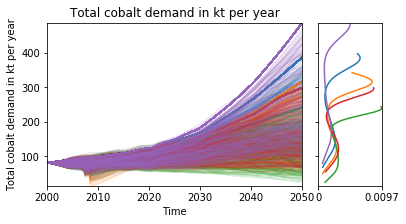

In [118]:
nice_lines(exp_b,out_b,out_to_show = 'Total demand[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Total cobalt demand in kt per year',
           convert_to_kt = True)

[MainProcess/WARNING] singular matrix
[MainProcess/WARNING] singular matrix


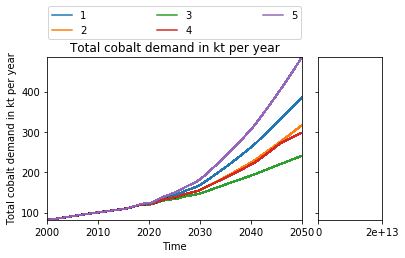

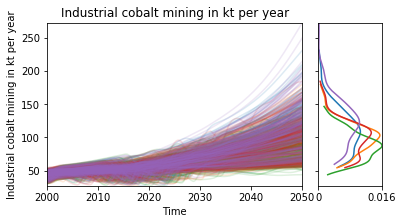

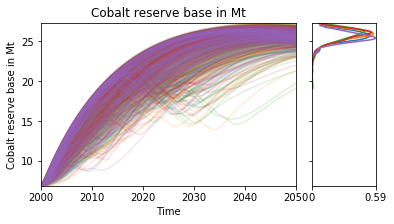

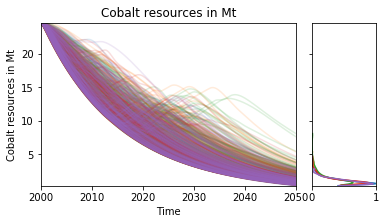

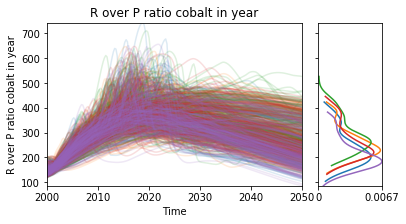

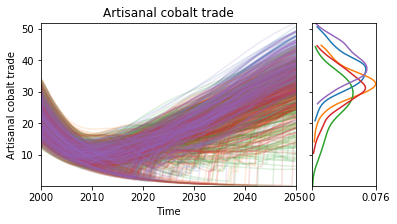

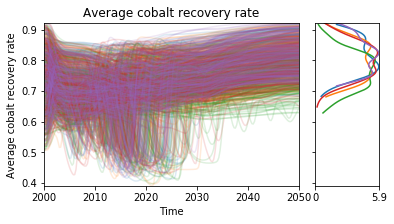

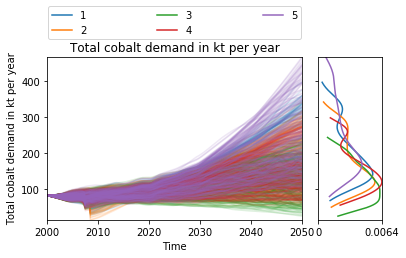

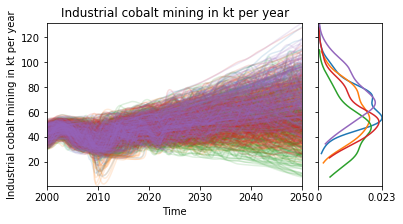

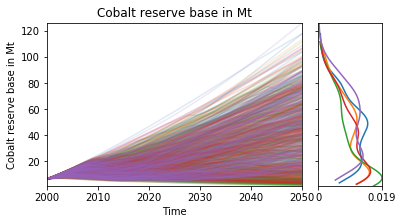

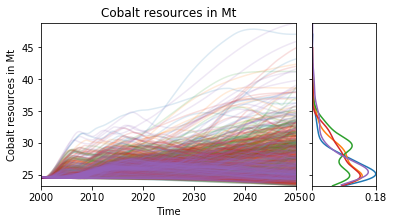

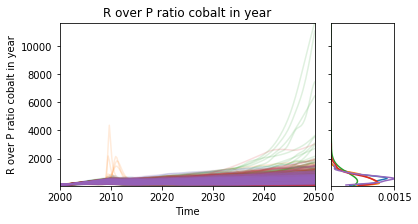

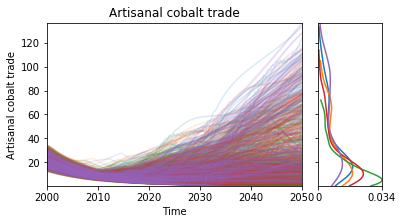

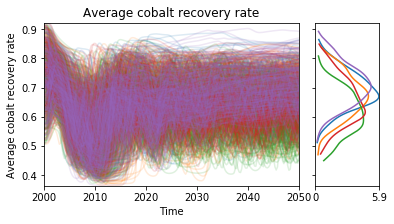

In [120]:
nice_lines(exp_fs,out_fs, out_to_show = 'Total demand[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Total cobalt demand in kt per year', 
           legend = True, paradigm = 'fs',
           convert_to_kt = True,)
nice_lines(exp_fs,out_fs, out_to_show = 'Industrial Ore mining[Cobalt]',
           group_by = 'Switch SSP', paradigm ='fs', density = Density.KDE, 
          title = 'Industrial cobalt mining in kt per year',convert_to_kt = True)
nice_lines(exp_fs,out_fs, paradigm = 'fs',out_to_show = 'Reserve base[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Cobalt reserve base in Mt',convert_to_Mt = True)
nice_lines(exp_fs,out_fs,  paradigm ='fs',out_to_show = 'Resources[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Cobalt resources in Mt',convert_to_Mt = True)
nice_lines(exp_fs,out_fs, paradigm = 'fs',out_to_show = 'R over P ratio[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'R over P ratio cobalt in year')
nice_lines(exp_fs,out_fs,  paradigm ='fs',out_to_show = 'Artisanal ore trade[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Artisanal cobalt trade',convert_to_kt = True)
nice_lines(exp_fs,out_fs, paradigm = 'fs',out_to_show = 'Average Co recovery rate',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Average cobalt recovery rate')

nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'Total demand[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Total cobalt demand in kt per year', legend = True,
           convert_to_kt = True,)
nice_lines(exp_oc,out_oc,  paradigm ='oc',out_to_show = 'Industrial Ore mining[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Industrial cobalt mining in kt per year',convert_to_kt = True)
nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'Reserve base[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Cobalt reserve base in Mt',convert_to_Mt = True)
nice_lines(exp_oc,out_oc,  paradigm ='oc',out_to_show = 'Resources[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Cobalt resources in Mt',convert_to_Mt = True)
nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'R over P ratio[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'R over P ratio cobalt in year')
nice_lines(exp_oc,out_oc, paradigm = 'oc',out_to_show = 'Artisanal ore trade[Cobalt]',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Artisanal cobalt trade',convert_to_kt = True)
nice_lines(exp_oc,out_oc,  paradigm ='oc',out_to_show = 'Average Co recovery rate',
           group_by = 'Switch SSP', density = Density.KDE, 
          title = 'Average cobalt recovery rate')



In [ ]:
#alternative
# x1 = clustering('oc', 'Total demand[Cobalt]',4)
# plot_clusters('oc', 'Total demand[Cobalt]',x1, zero = True)
# plt.show()
# fig,axs =plot_clusters('oc', 'Industrial Ore mining[Cobalt]',x1, zero = True)
# plt.show()
# fig,axs =plot_clusters('oc', 'Reserve base[Cobalt]',x1, zero = True)
# plt.show()
# fig,axs =plot_clusters('oc', 'Resources[Cobalt]',x1, zero = True)
# plt.show()
# fig,axs =plot_clusters('oc', 'R over P ratio[Cobalt]',x1, zero = True)
# plt.show()
# fig,axs =plot_clusters('oc', 'Artisanal ore trade[Cobalt]',x1, zero = True)
# plt.show()
# fig,axs =plot_clusters('oc', 'Average Co recovery rate',x1, zero = True)

# plt.show()

##  Visualize swing factors in production

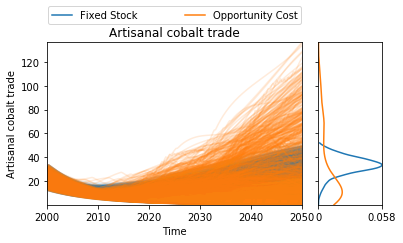

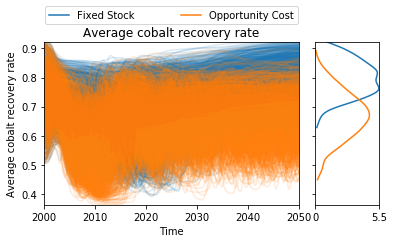

In [167]:
nice_lines(exp_b,out_b,  paradigm ='both',out_to_show = 'Artisanal ore trade[Cobalt]',
           group_by = 'Switch opportunity cost fixed stock', density = Density.KDE, 
          title = 'Artisanal cobalt trade',convert_to_kt = True, legend = True,
          grouping_specifiers = {'Fixed Stock':1, 'Opportunity Cost':2} )
nice_lines(exp_b,out_b, paradigm = 'both',out_to_show = 'Average Co recovery rate',
           group_by = 'Switch opportunity cost fixed stock', density = Density.KDE, 
          title = 'Average cobalt recovery rate',legend = True, 
           grouping_specifiers ={'Fixed Stock':1, 'Opportunity Cost':2} )


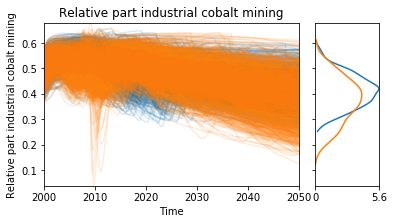

In [121]:
nice_lines(exp_b,out_b,  out_to_show = 'Relative part industrial mining[Cobalt]',
           group_by = 'Switch opportunity cost fixed stock', density = Density.KDE, 
          title = 'Relative part industrial cobalt mining')

## Visualize cobalt price

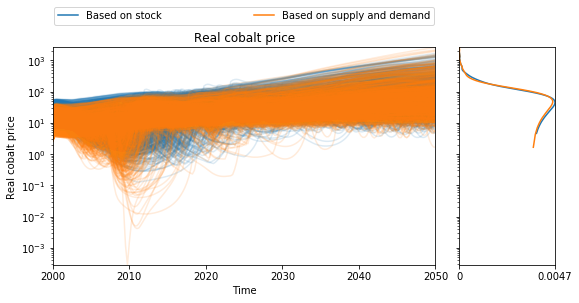

In [159]:
out_b['Real cobalt price'] = out_b['Real price[Cobalt]']
lines(exp_b, out_b, outcomes_to_show = 'Real cobalt price',
      group_by='Switch real price',
      grouping_specifiers = {'Based on stock':1, 'Based on supply and demand':2},
      density = Density.KDE)
fig = plt.gcf()
fig.set_size_inches(9,4)
plt.yscale('log')
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
fig.savefig(wd+'realprice_both.jpg')
plt.show()

## Visualize individual runs

In [284]:
exp_b[exp_b['Switch SSP'] == 2]

Switch opportunity cost fixed stock Switch SSP Switch carbon policy  \
11                                    1          2                    0   
14                                    1          2                    1   
16                                    1          2                    0   
17                                    1          2                    0   
31                                    1          2                    1   
33                                    1          2                    1   
53                                    1          2                    0   
54                                    1          2                    0   
57                                    1          2                    1   
64                                    1          2                    0   
70                                    1          2                    0   
71                                    1          2                    1   
72                                    1          2                    0   
79                                    1          2                    1   
81                                    1          2                    1   
86                                    1          2                    0   
90                                    1          2                    1   
101                                   1          2                    0   
110                                   1          2                    1   
116                                   1          2                    1   
117                                   1          2                    1   
124                                   1          2                    1   
128                                   1          2                    0   
131                                   1          2                    0   
132                                   1          2                    1   
135                                   1          2                    0   
137                                   1          2                    0   
142                                   1          2                    0   
146                                   1          2                    0   
151                                   1          2                    0   
..                                  ...        ...                  ...   
873                                   2          2                    1   
874                                   2          2                    0   
875                                   2          2                    0   
878                                   2          2                    0   
879                                   2          2                    1   
891                                   2          2                    1   
895                                   2          2                    0   
899                                   2          2                    0   
902                                   2          2                    0   
906                                   2          2                    0   
914                                   2          2                    0   
920                                   2          2                    0   
930                                   2          2                    0   
936                                   2          2                    0   
937                                   2          2                    0   
939                                   2          2                    1   
942                                   2          2                    0   
945                                   2          2                    0   
949                                   2          2                    0   
954                                   2          2                    1   
961                                   2          2                    1   
969                          

In [290]:
row1 = exp_b.index.values == 406
row2 = exp_b.index.values == 906

In [291]:
duh = np.array(np.array([row1 | row2],dtype='int'),dtype= 'object')

In [295]:
exp_b['dugh'] = duh[0]
exp_b['dugh'][906] = 2

C:\ProgramData\Anaconda3_32bits\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


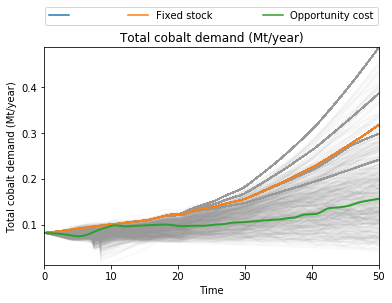

In [303]:
out_b['Total cobalt demand (Mt/year)'] = out_b['Total demand[Cobalt]']/2204622620
lines(exp_b, out_b, 'Total cobalt demand (Mt/year)',group_by = 'dugh' ,
      grouping_specifiers= {'Fixed stock': 1, 'Opportunity cost':2, '':0},legend=True)
fig = plt.gcf()
ax = fig.get_axes()
find_colors(ax[0])
for line in ax[0].get_lines():
    if line.get_color() == (0.12156862745098039, 0.4666666666666667, 0.7058823529411765):
        line.set_color((0.6,0.6,0.6))
        line.set_alpha(0.05)
    if line.get_color() == (1.0, 0.4980392156862745, 0.054901960784313725):
        line.set_alpha(1)
        line.set_linewidth(2)
    if line.get_color() == (0.17254901960784313, 0.6274509803921569, 0.17254901960784313):
        line.set_alpha(1)
        line.set_linewidth(2)

## Visualize influence of energy price growth scenario and oregrade

In [231]:
exp_b['High energy price'] = exp_b['Switch energy price growth scenario'] <3

In [180]:
exp_b['High power for oregrades'] = exp_b['Power for oregrades'] >0.4
exp_b['High power for oregrades'] = exp_b['High power for oregrades'].astype('object')

In [261]:
exp_b['Conditions high real price'] = exp_b['High energy price'] & exp_b['High power for oregrades']

In [262]:
exp_b['Conditions high real price'] = exp_b['Conditions high real price'].astype('object')

In [215]:
exp_b['Low energy price'] = exp_b['Switch energy price growth scenario'] ==3
exp_b['Low power for oregrades'] = exp_b['Power for oregrades'] <0.39
exp_b['Conditions low real price'] = exp_b['Low energy price'] & exp_b['Low power for oregrades']

In [265]:
exp_b['Conditions low real price'] = np.invert(exp_b['Conditions high real price'])

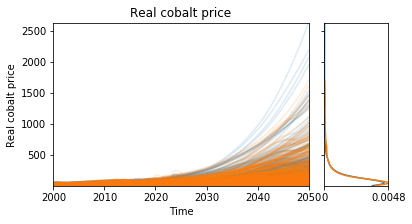

In [225]:
nice_lines(exp_b,out_b,  out_to_show = 'Real price[Cobalt]',
           exp_to_show = exp_b['Conditions high real price'].index.values,
           group_by = 'Switch carbon policy', density = Density.KDE, 
          title = 'Real cobalt price')

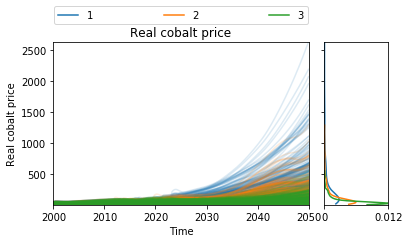

In [278]:
nice_lines(exp_b,out_b,out_to_show = 'Real price[Cobalt]',
          group_by = 'Switch energy price growth scenario',
#            grouping_specifiers = {'Medium \n energy \n price':2, 'High \n energy \n price':1,'Low \n energy \n price':3},
           legend  = True,
          density = Density.KDE, title = 'Real cobalt price')

In [281]:
exp_b['Low power for oregrades'] = np.invert(exp_b['High power for oregrades'])

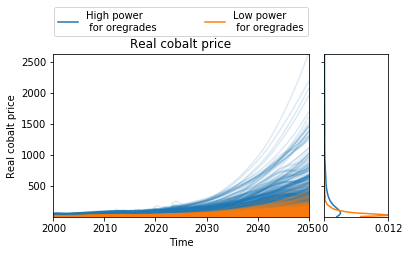

In [284]:
nice_lines(exp_b,out_b,out_to_show = 'Real price[Cobalt]',
          group_by = 'Low power for oregrades',
           grouping_specifiers = {'High power \n for oregrades':-2, 'Low power \n for oregrades':-1},
           legend  = True,
          density = Density.KDE, title = 'Real cobalt price')

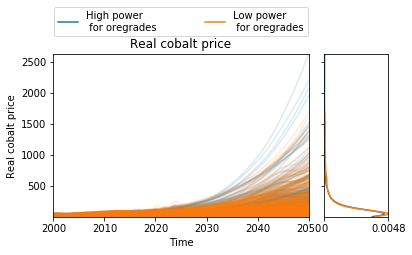

In [288]:
nice_lines(exp_b,out_b,out_to_show = 'Real price[Cobalt]',
          group_by = 'Switch carbon policy',
           grouping_specifiers = {'High power \n for oregrades':0, 'Low power \n for oregrades':1},
           legend  = True,
          density = Density.KDE, title = 'Real cobalt price')

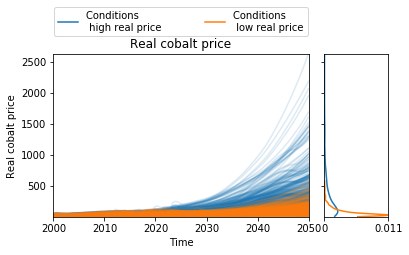

In [270]:
nice_lines(exp_b,out_b,out_to_show = 'Real price[Cobalt]',
          group_by = 'Conditions low real price',
           grouping_specifiers = {'Conditions \n high real price':-2, 'Conditions \n low real price':-1},
           legend  = True,
          density = Density.KDE, title = 'Real cobalt price')

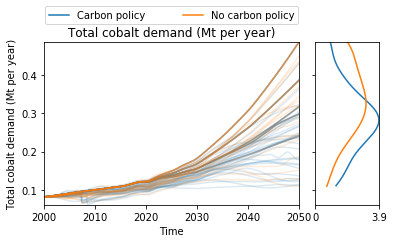

In [219]:
nice_lines(exp_b,out_b,  out_to_show = 'Total demand[Cobalt]',
           exp_to_show = exp_b[exp_b['Conditions low real price']].index.values,
           group_by = 'Switch carbon policy', legend=True,
           grouping_specifiers = {'No carbon policy':0, 'Carbon policy':1},
           density = Density.KDE, convert_to_Mt = True,
           title = 'Total cobalt demand (Mt per year)')


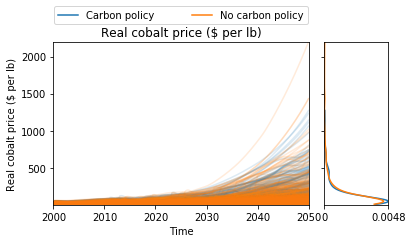

In [221]:
nice_lines(exp_b,out_b,  out_to_show = 'Real price[Cobalt]',
           group_by = 'Switch carbon policy', legend=True,
           grouping_specifiers = {'No carbon policy':0, 'Carbon policy':1},
           density = Density.KDE, 
           title = 'Real cobalt price ($ per lb)')

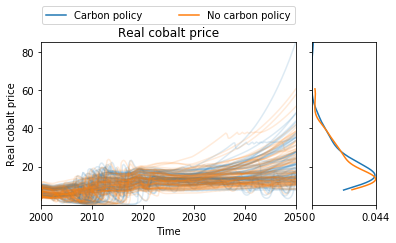

In [230]:
nice_lines(exp_b,out_b,  out_to_show = 'Real price[Cobalt]',
           exp_to_show = exp_b[exp_b['Conditions low real price']].index.values,
           group_by = 'Switch carbon policy', legend=True,
           grouping_specifiers = {'No carbon policy':0, 'Carbon policy':1},
           density = Density.KDE, 
           title = 'Real cobalt price')

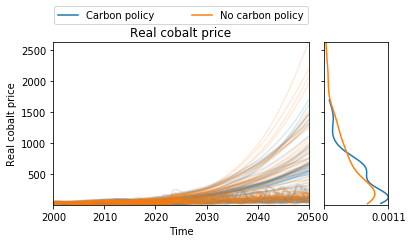

In [227]:
nice_lines(exp_b,out_b,  out_to_show = 'Real price[Cobalt]',
           exp_to_show = exp_b[exp_b['Conditions high real price']].index.values,
           group_by = 'Switch carbon policy', legend=True,
           grouping_specifiers = {'No carbon policy':0, 'Carbon policy':1},
           density = Density.KDE, 
           title = 'Real cobalt price')

##  Visualize energy usage mining

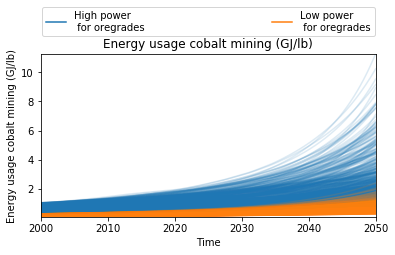

In [38]:
out_b['Energy usage cobalt mining (GJ/lb)'] = out_b['Energy usage mining[Cobalt]']
lines(exp_b,out_b, outcomes_to_show = 'Energy usage cobalt mining (GJ/lb)',
      group_by = 'High power for oregrades',legend=True,
      grouping_specifiers = {'Low power \n for oregrades':0, 'High power \n for oregrades':1},)
fig = plt.gcf()
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
fig.savefig(wd+'Energyusagemining.jpg')
plt.show()

## Visualize recycling input rate

In [46]:
exp_b['Collection rate cobalt products'] = pd.cut(exp_b['Collection rate metal products'],
                                                  [0.4,0.5,0.6,0.7,0.8],
                                                  labels=['40-50%','50-60%','60-70%','70-80%'])

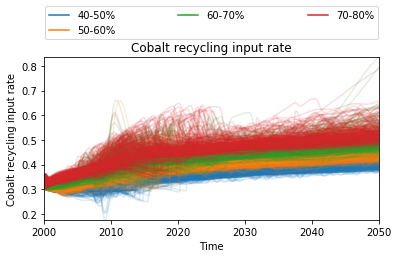

In [48]:
out_b['Cobalt recycling input rate'] = out_b['Recycling input rate[Cobalt]']
lines(exp_b,out_b, outcomes_to_show = 'Cobalt recycling input rate',
      group_by = 'Collection rate cobalt products',legend=True)
fig = plt.gcf()
fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
fig.savefig(wd+'cobaltrecyclinginputrate.jpg')
plt.show()

## Visualize profit industrial mining

In [50]:
out_b['Percentage profit industrial mining from Cobalt']  = sum([out_b['Percentage profit industrial mining capacity per metal[Cobalt,Sed hosted Co]'],
                                                               out_b['Percentage profit industrial mining capacity per metal[Cobalt,Ni laterite Co]'],
                                                               out_b['Percentage profit industrial mining capacity per metal[Cobalt,Magm sulfide Co]']])/3

In [69]:
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01

In [98]:
x3 = clustering('both','Percentage profit from cobalt, Sediment hosted deposit', 4)

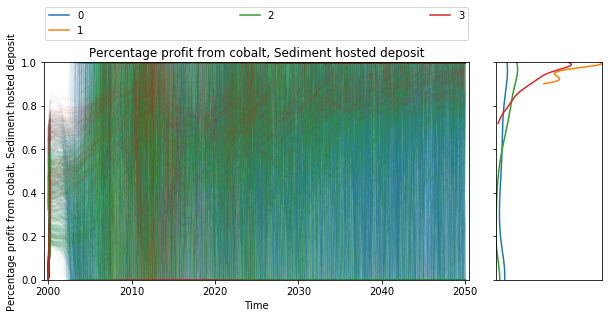

In [105]:
plot_clusters('both', 'Percentage profit from cobalt, Sediment hosted deposit', 
             x3, zero = True)
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(10,4)
ax[0].set_xticklabels([0,2000, 2010, 2020, 2030, 2040, 2050])
for line in ax[0].get_lines():
    line.set_alpha(0.04)
#     print(line.get_colors())
plt.show()

In [144]:
exp_b['Switch fixed stock opportunity cost'] = np.invert(exp_b['Switch opportunity cost fixed stock']).astype(object)

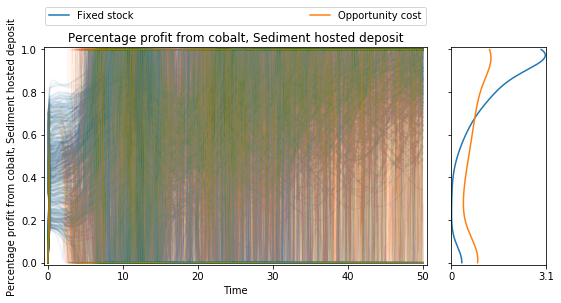

In [151]:
out_b['Percentage profit from cobalt, Sediment hosted deposit'] = out_b['Percentage profit industrial mining capacity per metal[Cobalt,Sed hosted Co]']
lines(exp_b, out_b, outcomes_to_show ='Percentage profit from cobalt, Sediment hosted deposit' ,
      group_by='Switch fixed stock opportunity cost',
      grouping_specifiers = {'Fixed stock':-2,'Opportunity cost':-3},
      density = Density.KDE)
fig = plt.gcf()
axs = fig.get_axes()
fig.set_size_inches(9,4)
for line in axs[0].get_lines():
    line.set_alpha(0.02)
    if line.get_color() == (1.0, 0.4980392156862745, 0.054901960784313725):
        line.set_alpha(0.01)
    else:
        line.set_alpha(0.08)
        #         line.set_color((0.2,0.2,0.2))
#     else:
#         line.set_color((0.8,0.8,0.8))


In [122]:
x4 = clustering('both','Percentage profit industrial mining from Cobalt', 5)

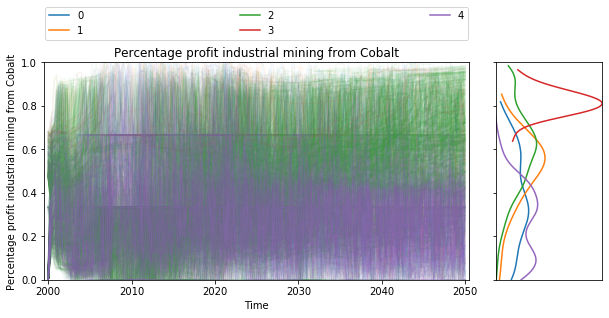

In [123]:
plot_clusters('both', 'Percentage profit industrial mining from Cobalt', 
             x4, zero = True)
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(10,4)
ax[0].set_xticklabels([0,2000, 2010, 2020, 2030, 2040, 2050])
for line in ax[0].get_lines():
    line.set_alpha(0.05)
#     print(line.get_colors())
plt.show()

## some more real price visualizations

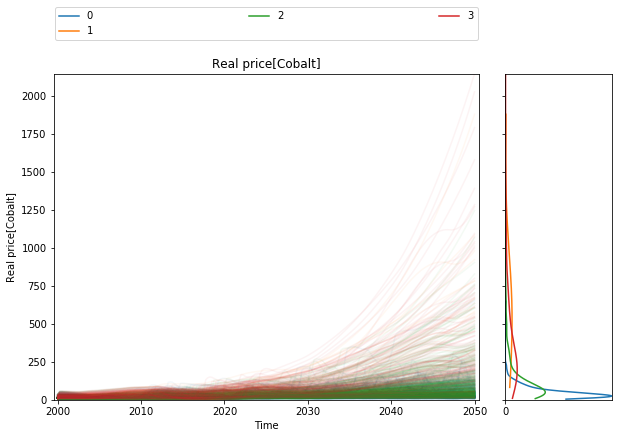

In [133]:
plot_clusters('both', 'Real price[Cobalt]', 
             x3, zero = True)
# plt.yscale('log')
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(10,6)
ax[0].set_xticklabels([0,2000, 2010, 2020, 2030, 2040, 2050])
for line in ax[0].get_lines():
    line.set_alpha(0.05)
#     print(line.get_colors())
plt.show()

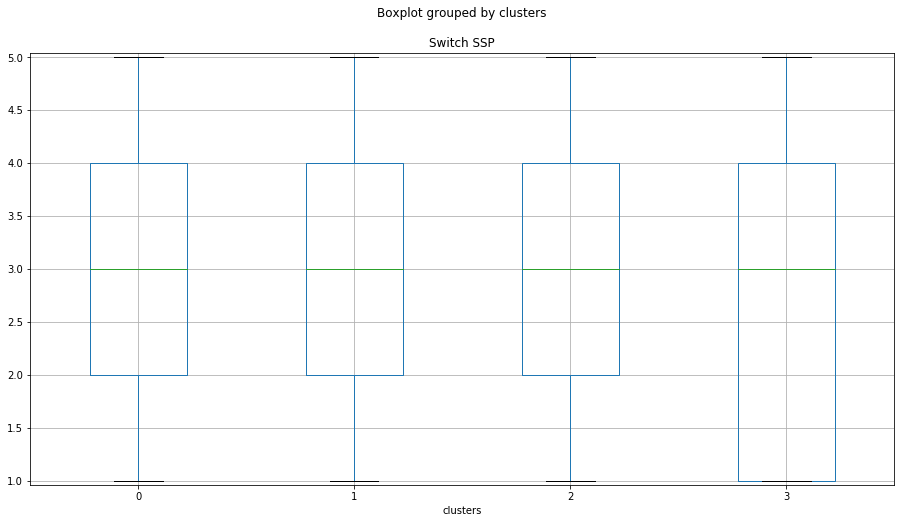

In [116]:
clusters_boxplot('both', 'Switch SSP',x4)

C:\ProgramData\Anaconda3_32bits\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3_32bits\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


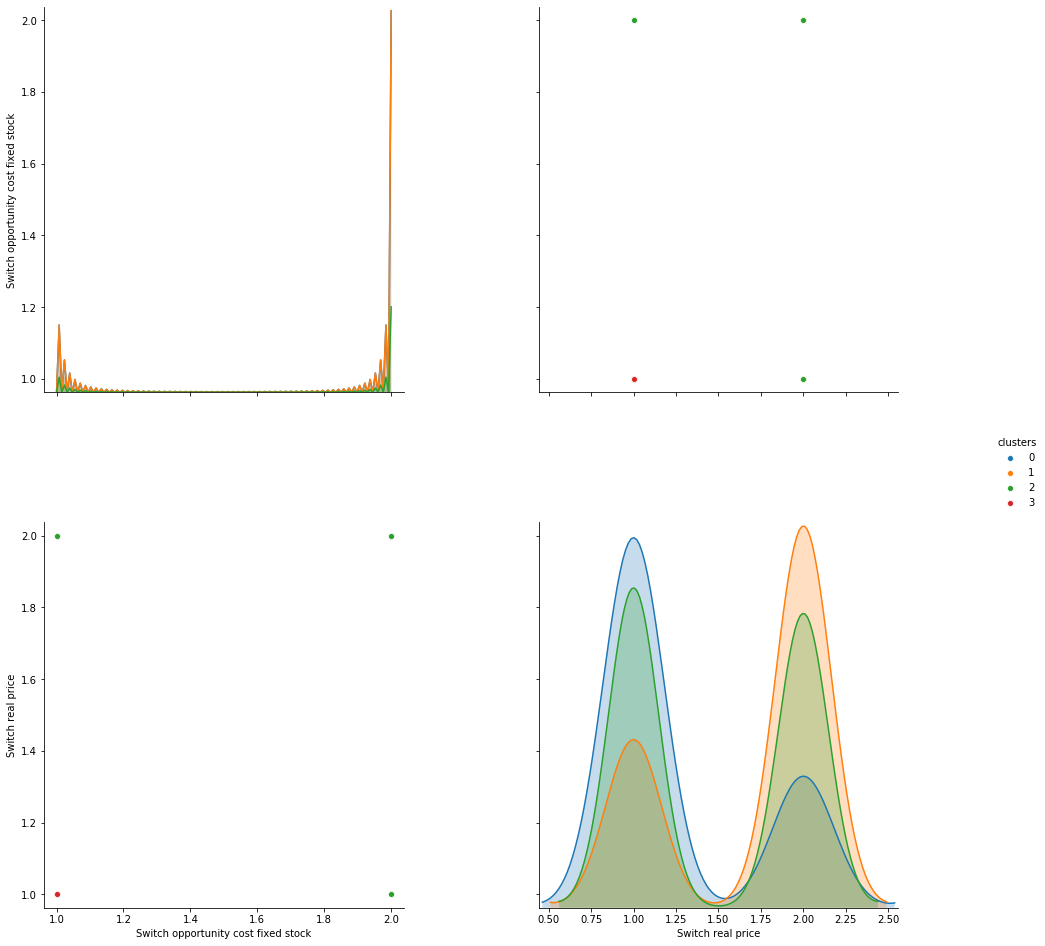

In [110]:
clusters_pairplotting(x4,['Switch opportunity cost fixed stock','Switch real price' ])

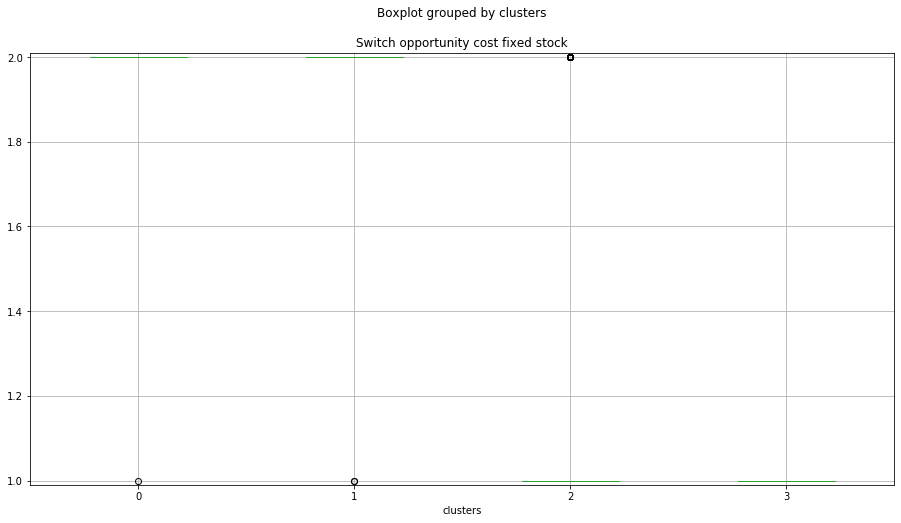

In [109]:
clusters_boxplot('both','Switch opportunity cost fixed stock',x4)

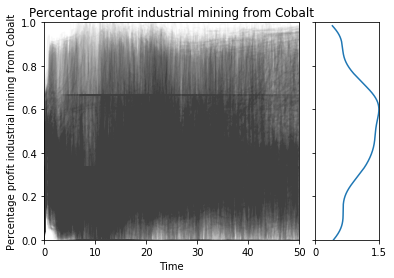

In [61]:
lines(exp_b, out_b, outcomes_to_show ='Percentage profit industrial mining from Cobalt',density = Density.KDE )
fig = plt.gcf()
axs = fig.get_axes()
for line in axs[0].get_lines():
    line.set_alpha(0.03)
    line.set_color((0.25,0.25,0.25))

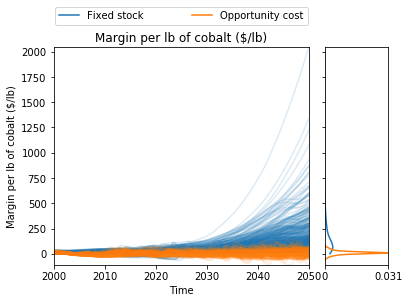

In [190]:
out_b['Margin per lb of cobalt ($/lb)'] = out_b['Marge per lb[Cobalt]']
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt ($/lb)',
      group_by='Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
# fig.set_size_inches(6,3)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
plt.show()

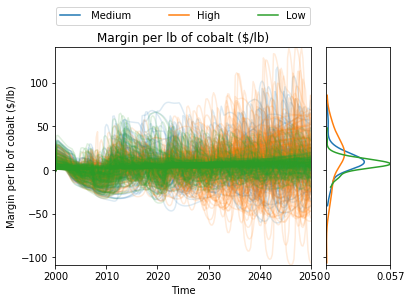

In [181]:
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt ($/lb)', 
      experiments_to_show = exp_b[exp_b['Switch opportunity cost fixed stock']==2].index.values,
      group_by='Switch energy price growth scenario',
      grouping_specifiers = {'High': 1,' Medium':2,'Low':3},
      density = Density.KDE)
fig = plt.gcf()
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
plt.show()

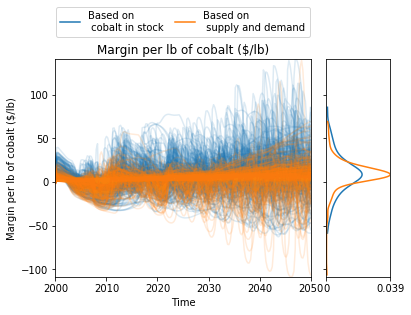

In [184]:
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt ($/lb)', 
      experiments_to_show = exp_b[exp_b['Switch opportunity cost fixed stock']==2].index.values,
      group_by='Switch real price', #energy price growth scenario',
      grouping_specifiers = {'Based on \n cobalt in stock': 1,'Based on \n supply and demand':2,},
      density = Density.KDE)
fig = plt.gcf()
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
plt.show()

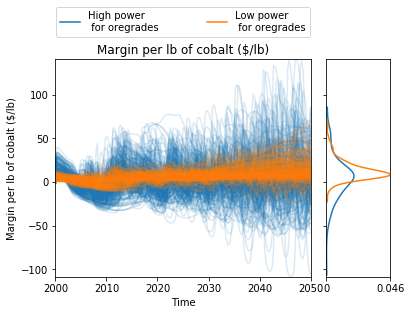

In [189]:
lines(exp_b,out_b, outcomes_to_show = 'Margin per lb of cobalt ($/lb)', 
      experiments_to_show = exp_b[exp_b['Switch opportunity cost fixed stock']==2].index.values,
      group_by='High power for oregrades', #energy price growth scenario',
      grouping_specifiers = {'High power \n for oregrades ': 1,'Low power \n for oregrades':0},
      density = Density.KDE)
fig = plt.gcf()
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
plt.show()

## Visualize cobalt mining capacity % sediment hosted

In [208]:
out_b['Indstrial mining capacity cobalt, sediment hosted (Mt/year)'] = out_b['Industrial mining capacity[Sed hosted Co]']/2204622620 * 0.054
out_b['Indstrial mining capacity cobalt, Ni laterite (Mt/year)'] = out_b['Industrial mining capacity[Ni laterite Co]']/2204622620 * 0.0482
out_b['Indstrial mining capacity cobalt, Magmatic sulfide (Mt/year)'] = out_b['Industrial mining capacity[Magm sulfide Co]']/2204622620 * 0.0061

out_b['% industrial cobalt mining from sediment hosted'] = out_b['Indstrial mining capacity cobalt, sediment hosted (Mt/year)'] / (out_b['Indstrial mining capacity cobalt, sediment hosted (Mt/year)'] + out_b['Indstrial mining capacity cobalt, Ni laterite (Mt/year)'] + out_b['Indstrial mining capacity cobalt, Magmatic sulfide (Mt/year)'])




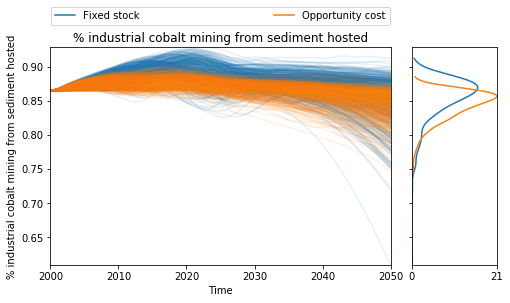

In [213]:
lines(exp_b,out_b,outcomes_to_show = '% industrial cobalt mining from sediment hosted', 
     group_by = 'Switch opportunity cost fixed stock',
      grouping_specifiers = {'Fixed stock':1,'Opportunity cost':2},
      density = Density.KDE)
fig = plt.gcf()
fig.set_size_inches(8,4)
ax = fig.get_axes()
ax[0].set_xticklabels(labels_time)
for line in ax[0].get_lines():
    line.set_alpha(0.1)
plt.show()

## Graph dump

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


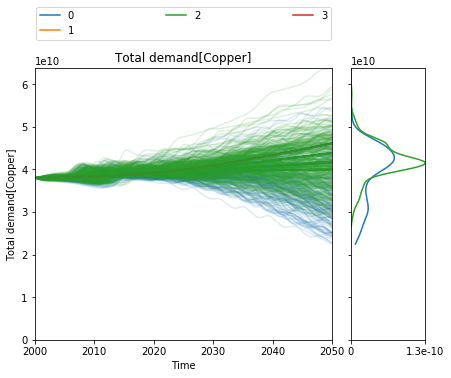

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


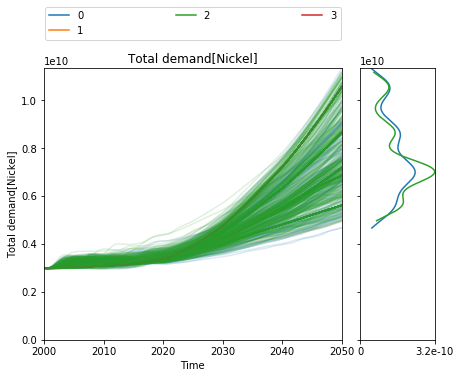

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


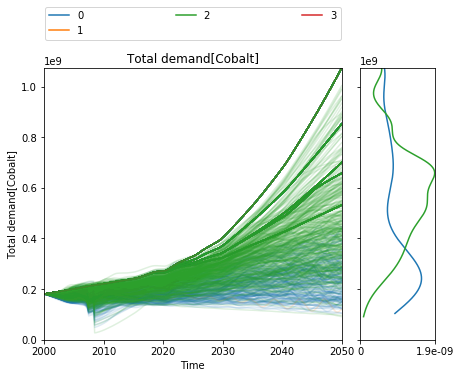

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


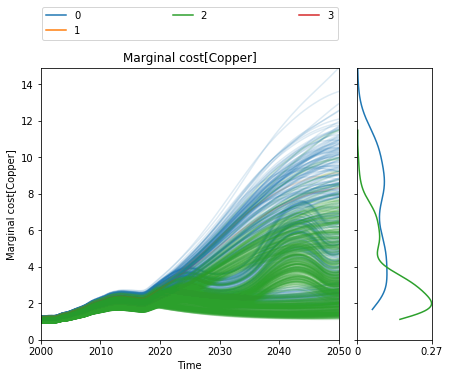

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


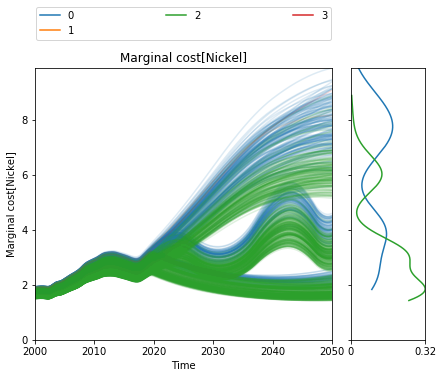

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


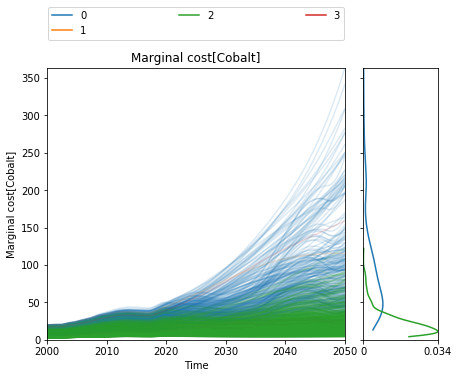

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


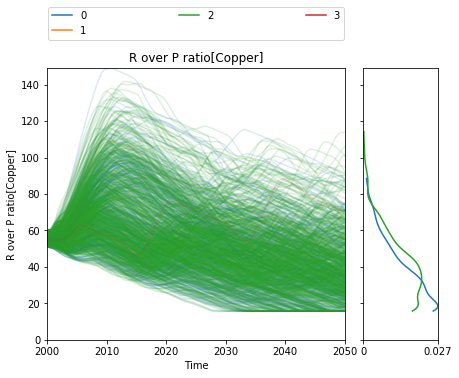

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


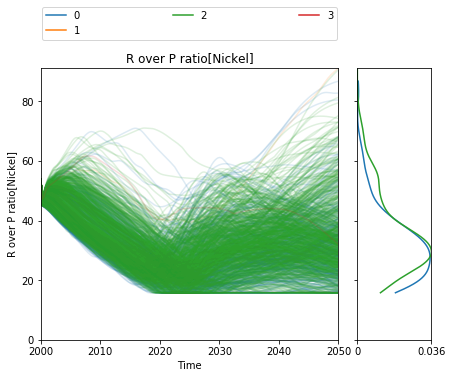

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


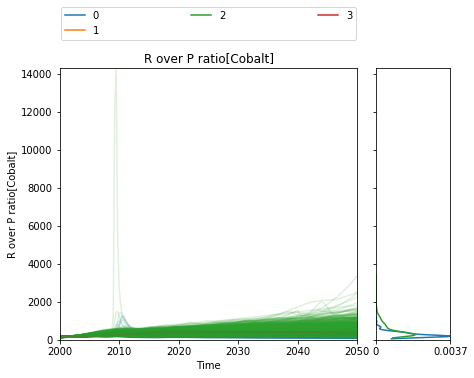

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


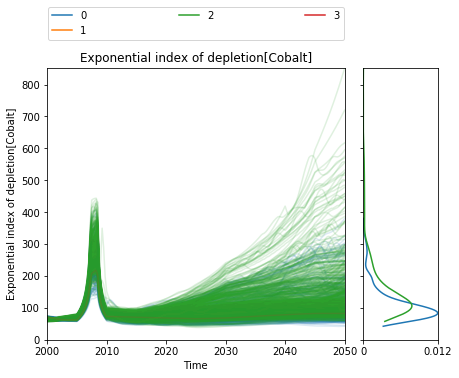

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


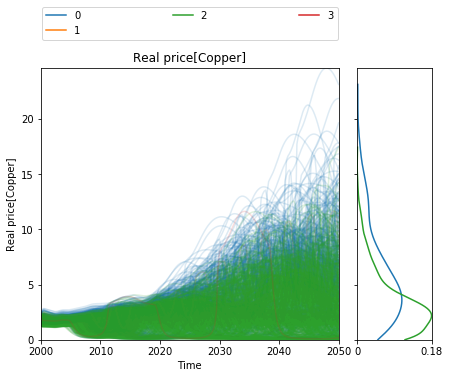

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


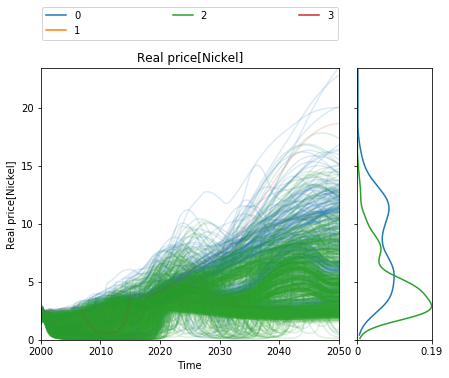

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


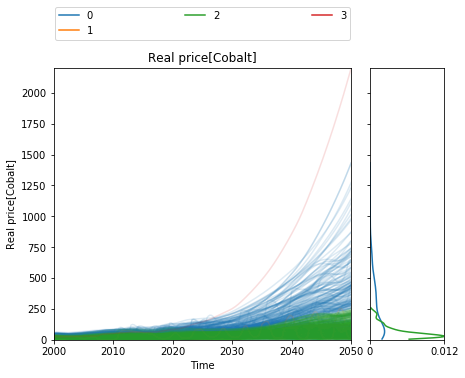

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


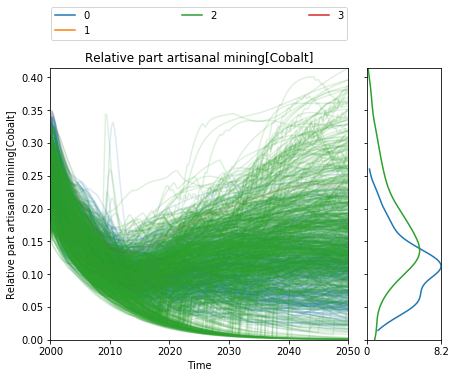

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


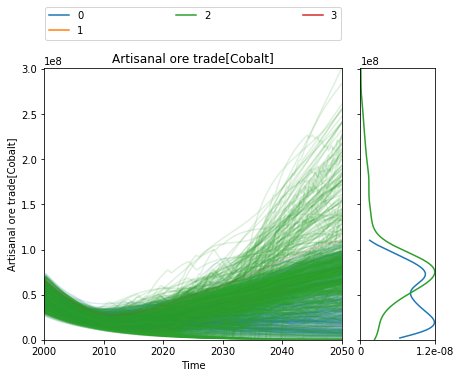

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


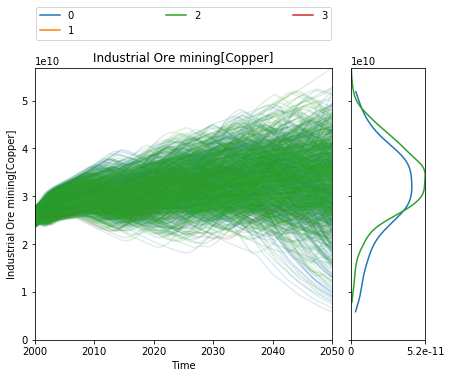

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


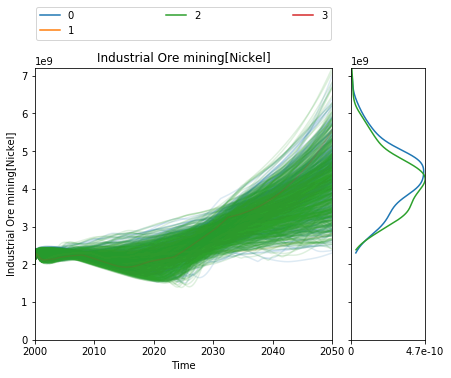

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


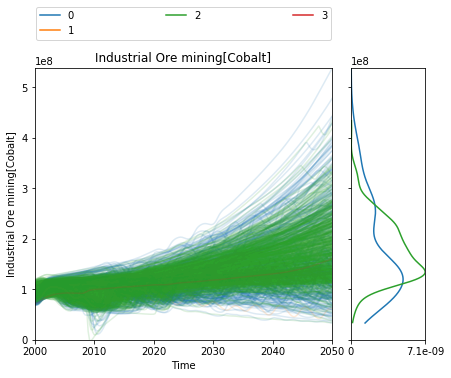

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


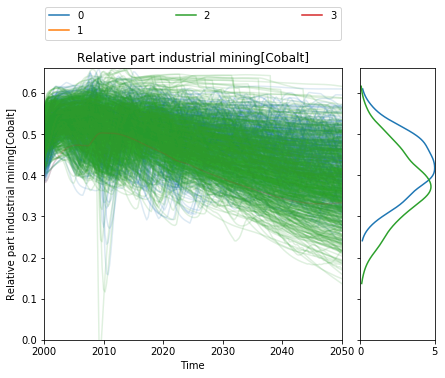

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


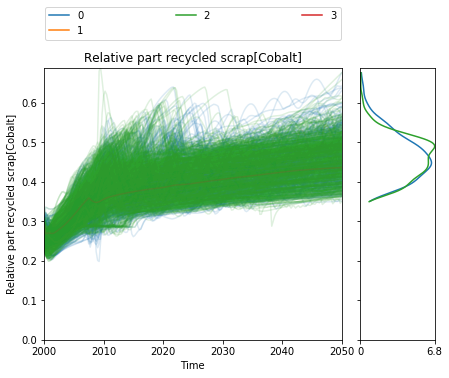

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


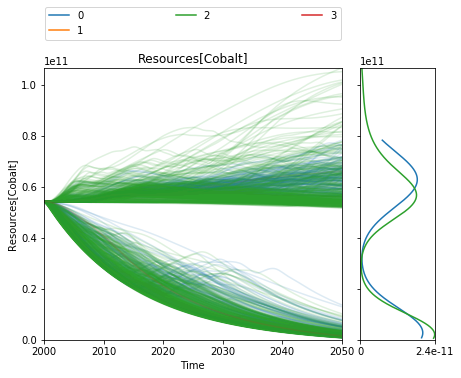

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


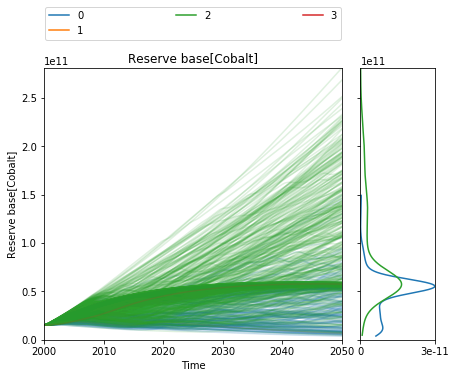

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


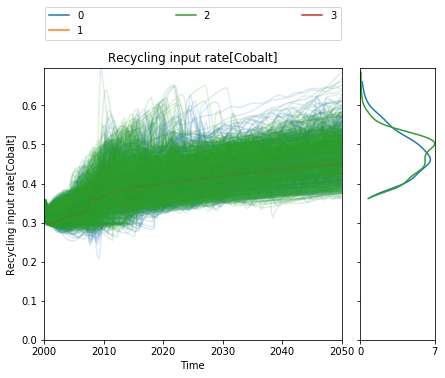

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


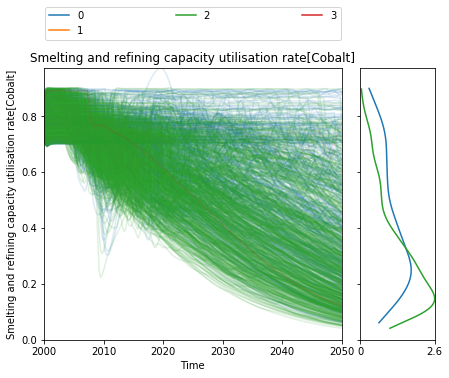

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


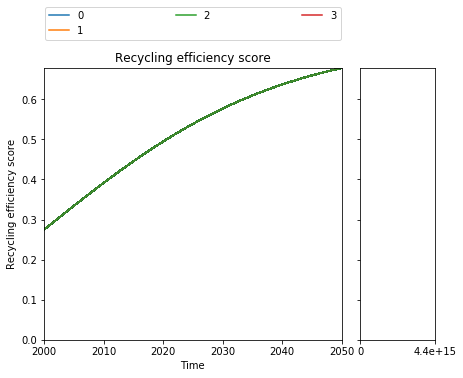

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


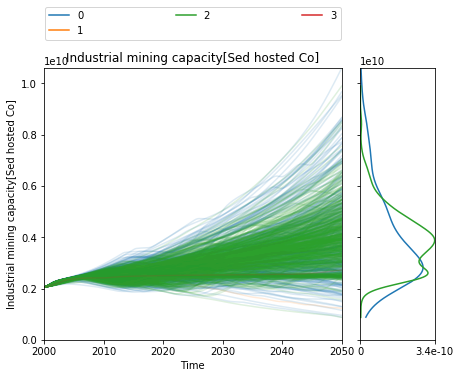

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


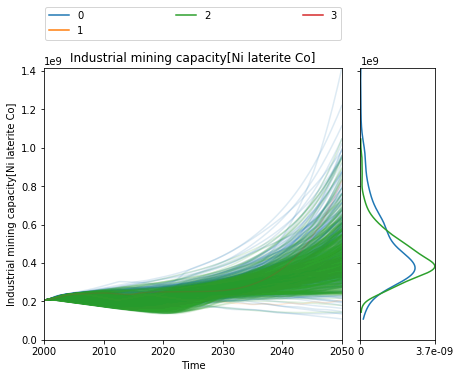

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


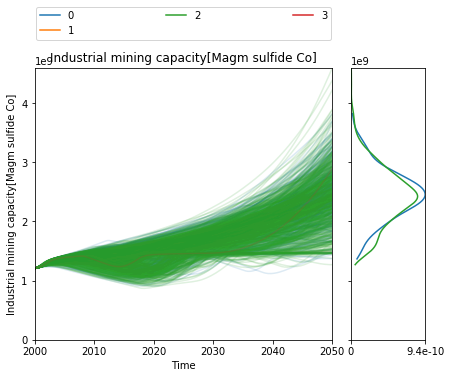

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


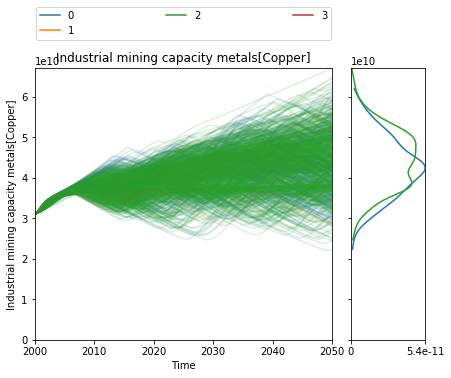

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


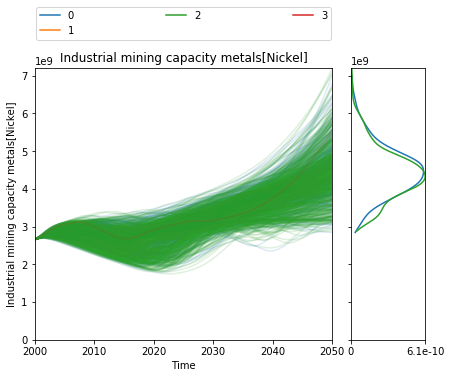

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


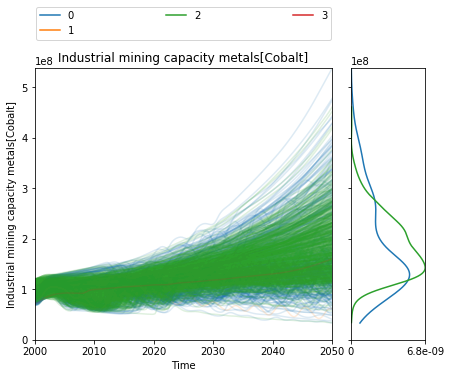

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


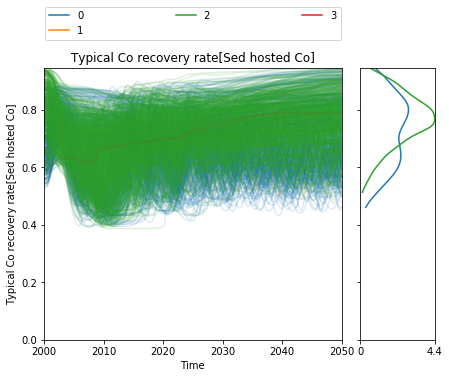

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


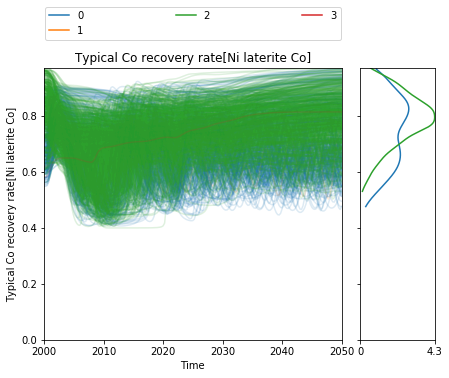

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


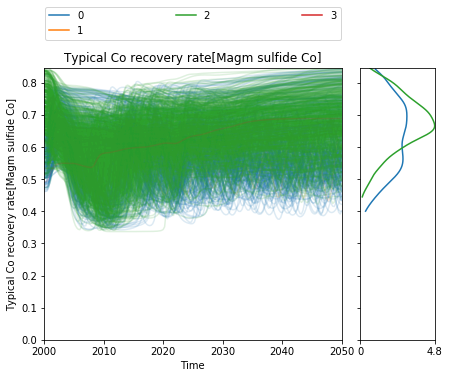

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


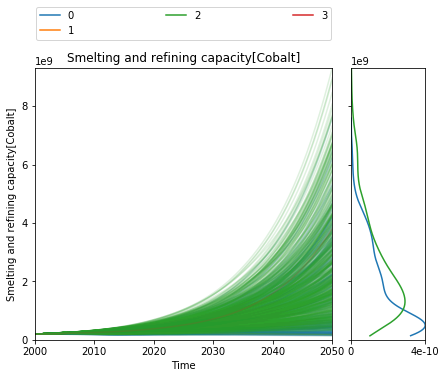

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


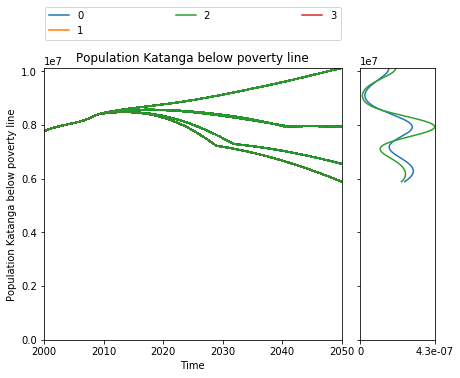

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


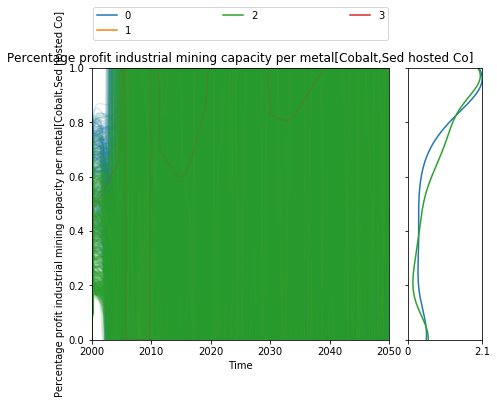

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


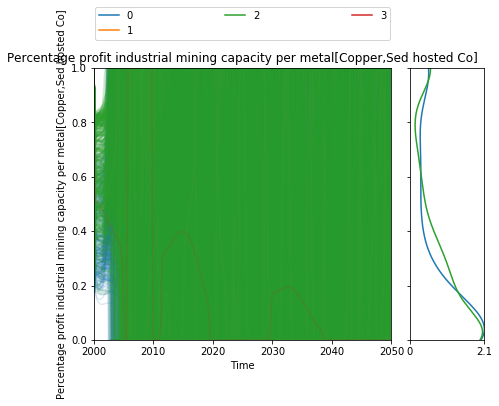

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


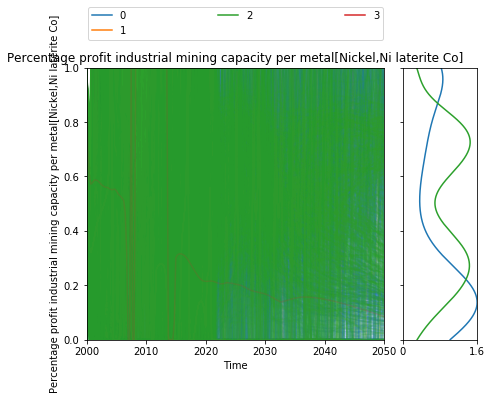

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


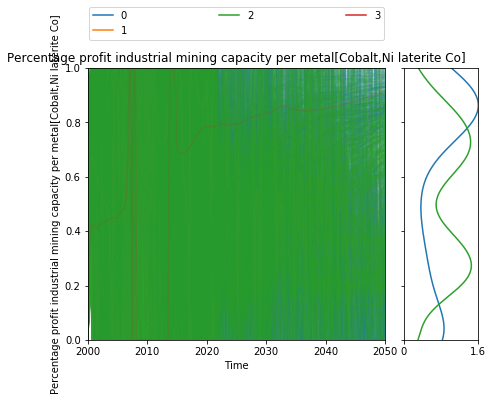

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


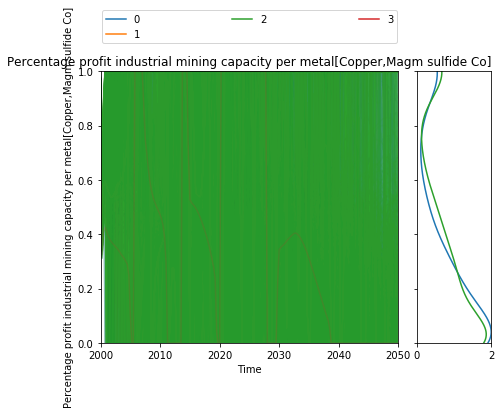

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


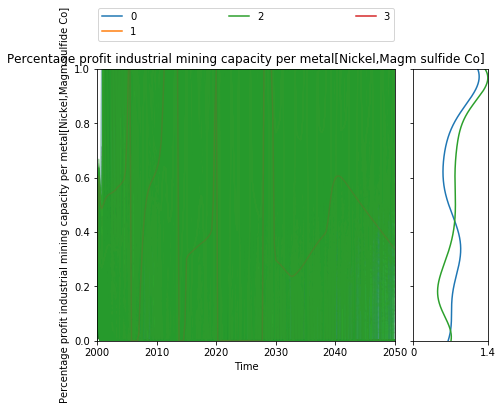

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


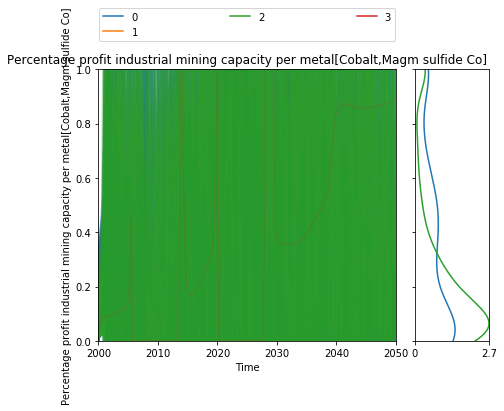

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


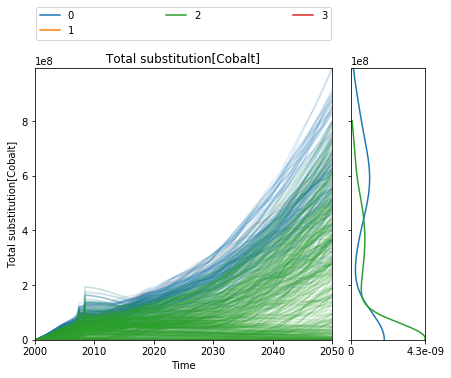

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


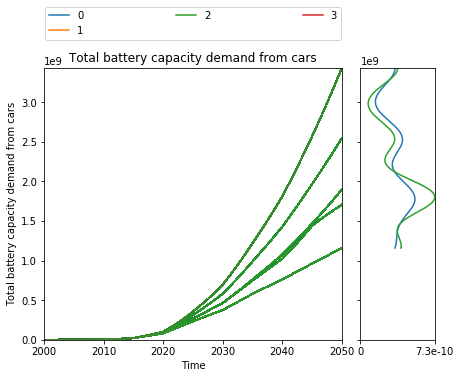

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


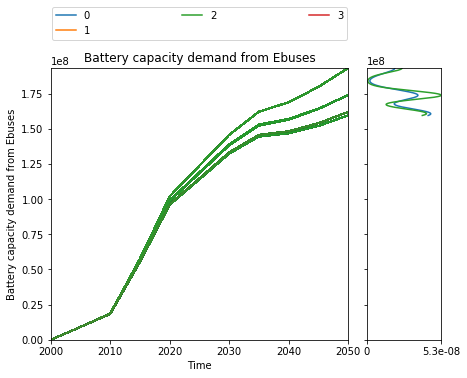

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


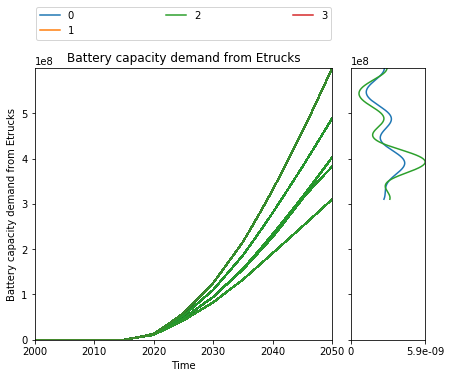

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


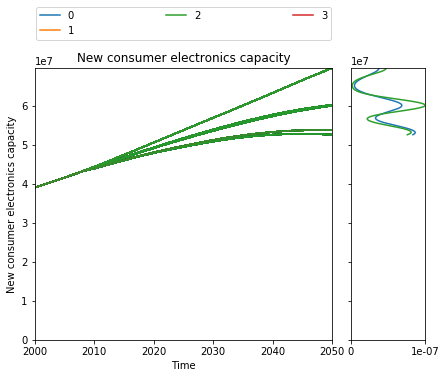

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


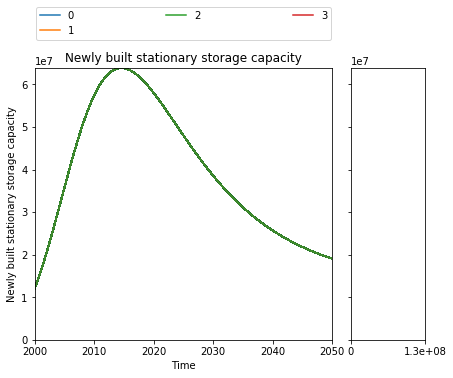

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


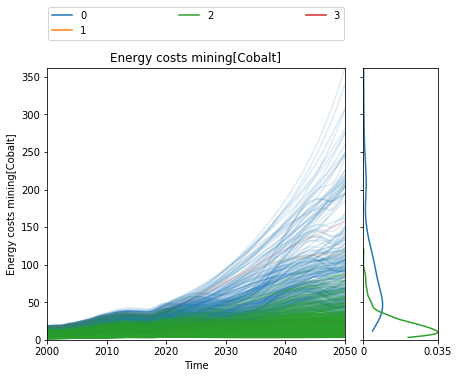

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


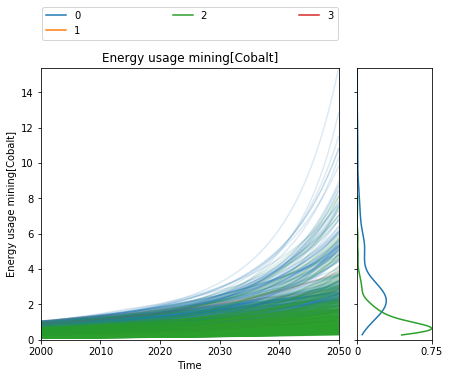

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


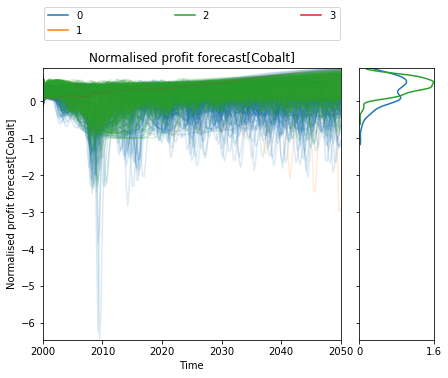

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.


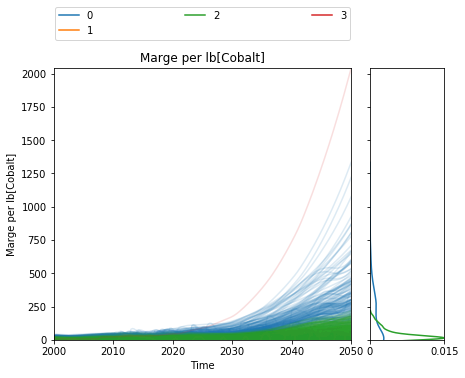

[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` input should have multiple elements.
[MainProcess/WARNING] `dataset` in

KeyboardInterrupt: 

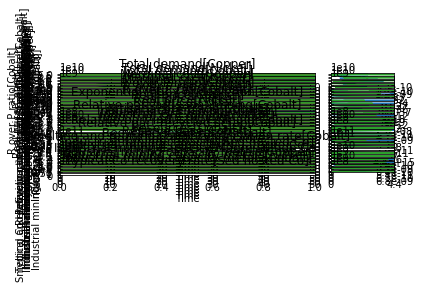

In [306]:
x = clustering('both', 'Real price[Cobalt]', 4)

for i in out_b:
    if i != 'TIME':
        if i == 'Normalised profit forecast[Copper]':
            fig,axes=plot_clusters('both', i , x, zero= False)
        elif i == 'Normalised profit forecast[Nickel]':
            fig,axes=plot_clusters('both', i , x, zero= False)
        elif i == 'Normalised profit forecast[Cobalt]':
            fig,axes=plot_clusters('both', i , x, zero= False)
        else:
            fig,axes = plot_clusters('both', i , x, zero= True )
        plt.show()

## Pairplotting for real price

C:\ProgramData\Anaconda3_32bits\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3_32bits\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3_32bits\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3_32bits\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


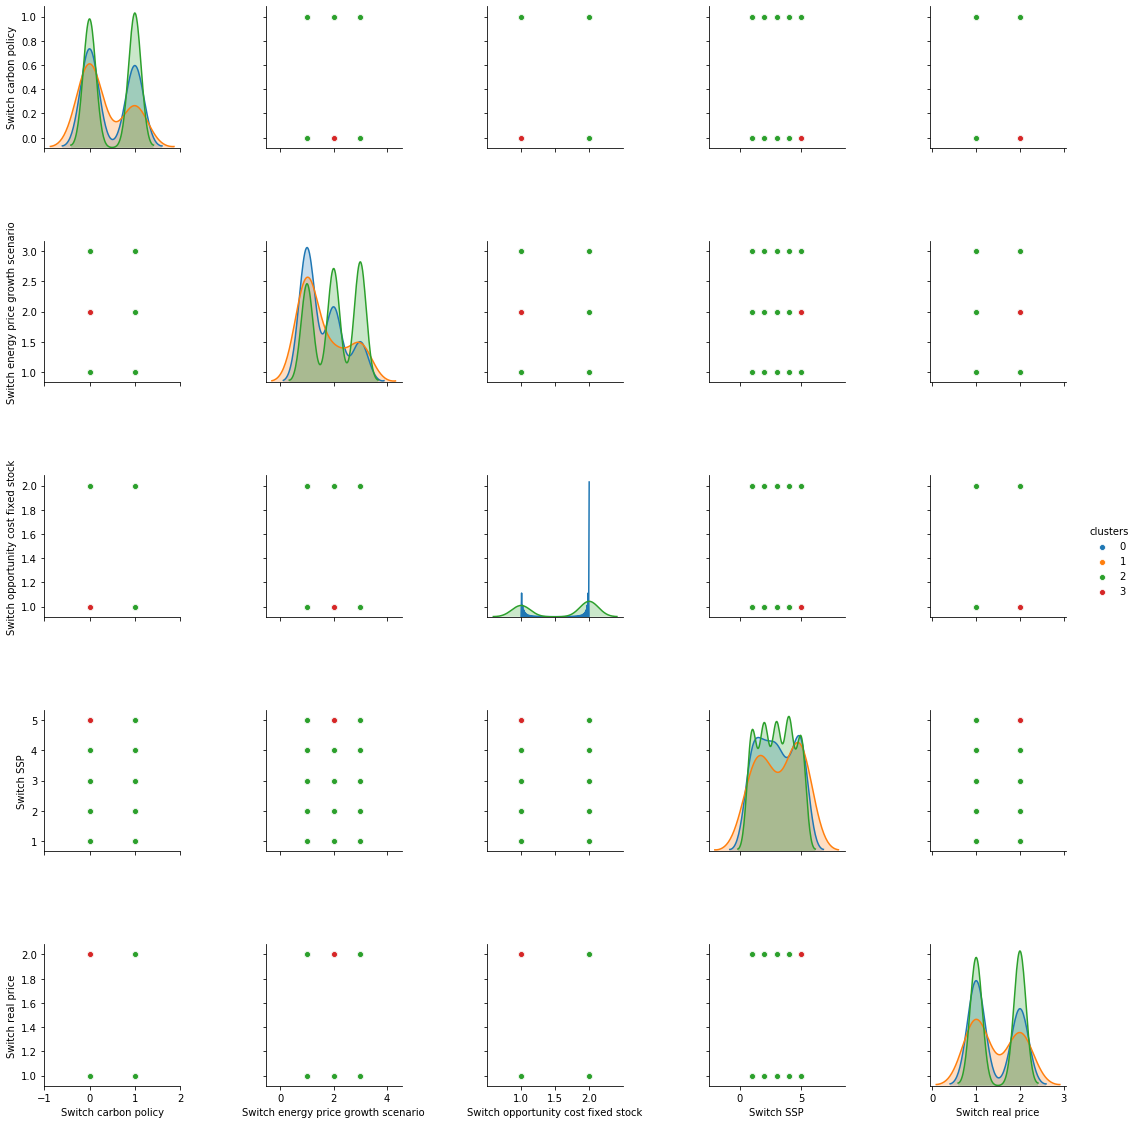

In [118]:
x = clustering('both', 'Real price[Cobalt]', 4)
clusters_pairplotting(x, ['Switch carbon policy', 'Switch energy price growth scenario', 
                          'Switch opportunity cost fixed stock',
                         'Switch SSP', 'Switch real price'])

### Influence of price mechanism

### PRIM

In [119]:
from ema_workbench.analysis import prim

In [120]:
x = exp_b

# if higher than threshold set to true
y =  out_b['Real price[Cobalt]'] > 15.15

print(x.shape)
print(y.shape)

# if anywhere over the run true, than true
y = np.any(y, axis=1)

print(y.shape)

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 1000 points remaining, containing 877 cases of interest


(1000, 75)
(1000, 201)
(1000,)


[MainProcess/INFO] mean: 1.0, mass: 0.408, coverage: 0.4652223489167617, density: 1.0 restricted_dimensions: 3


In [121]:
# x = exp_b

# # if higher than threshold set to true
# y =  np.any(out_b['Real price[Cobalt]'] > 15.15, axis=1)

# prim_alg = prim.Prim(x, y, threshold=0.8)
# box1 = prim_alg.find_box()

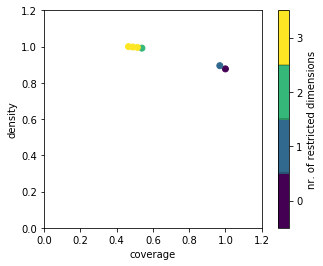

In [122]:
box1.show_tradeoff()
plt.show()

In [123]:
box1.inspect()

coverage    0.465222
density            1
id                 5
mass           0.408
mean               1
res_dim            3
Name: 5, dtype: object

                                        box 5            \
                                          min       max   
Switch opportunity cost fixed stock       {1}       {1}   
Power for oregrades                  0.385773  0.419978   
Price amplifying factor              0.636747   2.99983   

                                                                    
                                                         qp values  
Switch opportunity cost fixed stock  [4.309677684673634e-15, -1.0]  
Power for oregrades                     [0.0315037777327904, -1.0]  
Price amplifying factor                [0.38504833770498337, -1.0]  



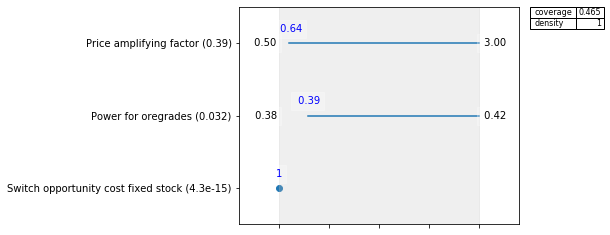

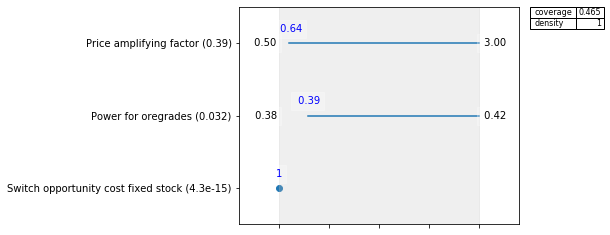

In [124]:
box1.inspect(5, style='graph', boxlim_formatter="{: .2f}")

   coverage   density id   mass      mean res_dim
0  1.000000  0.877000  0  1.000  0.877000       0
1  0.969213  0.894737  1  0.950  0.894737       1
2  0.539339  0.991614  2  0.477  0.991614       2
3  0.514253  0.995585  3  0.453  0.995585       3
4  0.489168  0.997674  4  0.430  0.997674       3
5  0.465222  1.000000  5  0.408  1.000000       3


Switch opportunity cost fixed stock [1, 2]


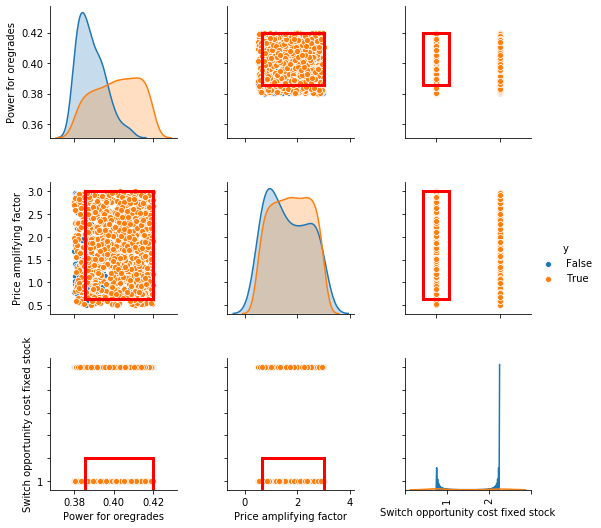

In [125]:
box1.select(5)
box1.write_ppt_to_stdout()
box1.show_pairs_scatter(5)

In [132]:
def classify(data):
    # get the output for deceased population
    ooi = data['Real price[Copper]']
    return ooi[:, -1]  > 15.15

In [134]:
prim_obj = prim.setup_prim(results_both, classify, threshold=0.8, threshold_type=-1)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


In [135]:
box_1 = prim_obj.find_box()


[MainProcess/INFO] 1000 points remaining, containing 983 cases of interest
[MainProcess/INFO] mean: 0.27450980392156865, mass: 0.051, coverage: 0.03763987792472025, density: 0.7254901960784313 restricted_dimensions: 8


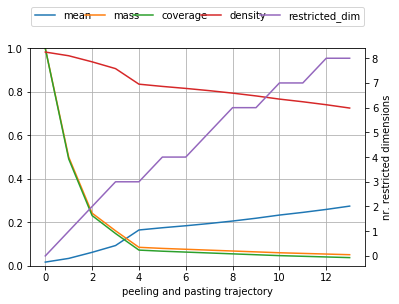

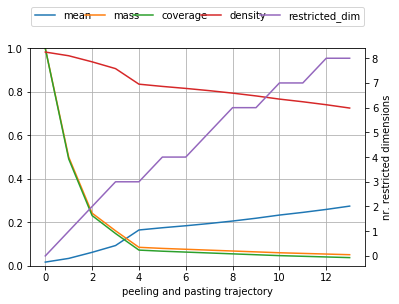

In [136]:
box_1.show_ppt()


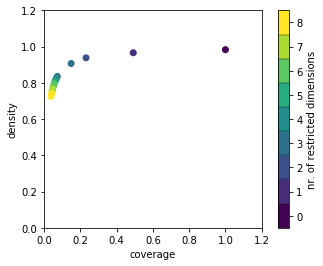

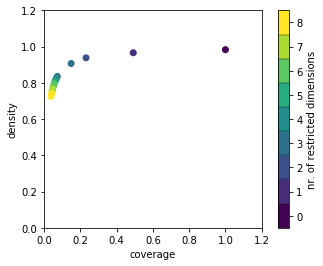

In [137]:
box_1.show_tradeoff()


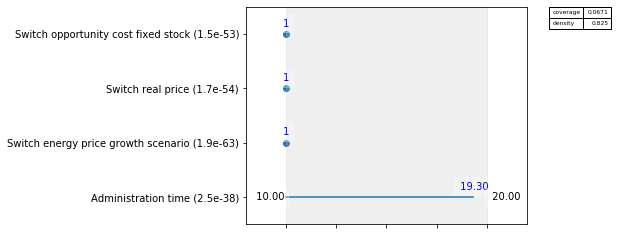

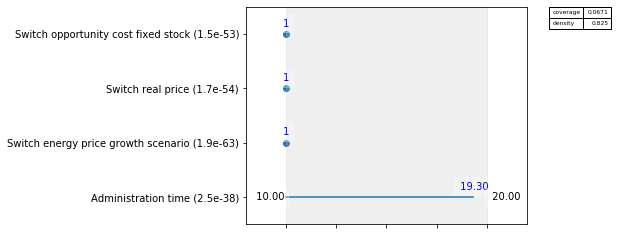

In [138]:
box_1.inspect(5, style='graph', boxlim_formatter="{: .2f}")


In [139]:
box_1.inspect(5)


coverage    0.0671414
density         0.825
id                  5
mass             0.08
mean            0.175
res_dim             4
Name: 5, dtype: object

                                       box 5           \
                                         min      max   
Administration time                  10.0039  19.3048   
Switch energy price growth scenario      {1}      {1}   
Switch real price                        {1}      {1}   
Switch opportunity cost fixed stock      {1}      {1}   

                                                                     
                                                          qp values  
Administration time                  [-1.0, 2.5421653612580965e-38]  
Switch energy price growth scenario  [1.8587827370722424e-63, -1.0]  
Switch real price                    [1.7498618491408268e-54, -1.0]  
Switch opportunity cost fixed stock  [1.5173025077550741e-53, -1.0]  



    coverage   density  id   mass      mean res_dim
0   1.000000  0.983000   0  1.000  0.017000       0
1   0.491353  0.966000   1  0.500  0.034000       1
2   0.230926  0.938017   2  0.242  0.061983       2
3   0.148525  0.906832   3  0.161  0.093168       3
4   0.072228  0.835294   4  0.085  0.164706       3
5   0.067141  0.825000   5  0.080  0.175000       4
6   0.063072  0.815789   6  0.076  0.184211       4
7   0.059003  0.805556   7  0.072  0.194444       5
8   0.054934  0.794118   8  0.068  0.205882       6
9   0.050865  0.781250   9  0.064  0.218750       6
10  0.046796  0.766667  10  0.060  0.233333       7
11  0.043744  0.754386  11  0.057  0.245614       7
12  0.040692  0.740741  12  0.054  0.259259       8
13  0.037640  0.725490  13  0.051  0.274510       8


Switch energy price growth scenario [1, 2, 3]
Switch opportunity cost fixed stock [1, 2]
Switch real price [1, 2]


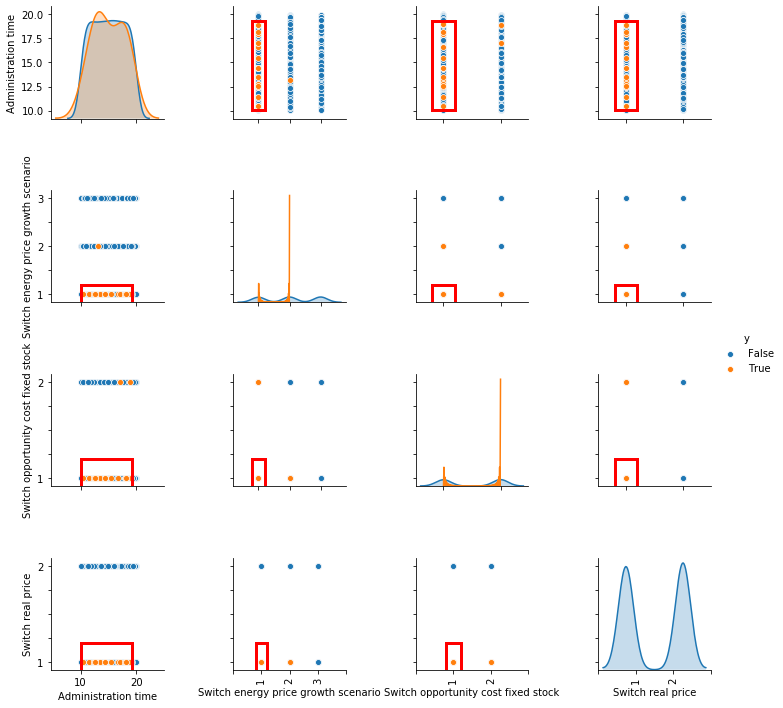

In [140]:
box_1.select(5)
box_1.write_ppt_to_stdout()
box_1.show_pairs_scatter(5)



       coverage  density  mass  res_dim
box 1  0.067141    0.825  0.08        4
                                       box 1         
                                         min      max
Switch energy price growth scenario      {1}      {1}
Switch opportunity cost fixed stock      {1}      {1}
Switch real price                        {1}      {1}
Administration time                  10.0039  19.3048


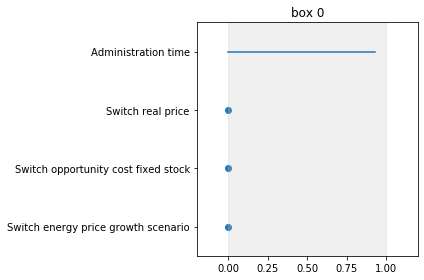

In [141]:
# print prim to std_out
print(prim_obj.stats_to_dataframe())
print(prim_obj.boxes_to_dataframe())

# visualize
prim_obj.show_boxes()
plt.show()

## Influence of uncertainties on outcomes

In [144]:
feat_scoring_both = feature_scoring.get_feature_scores_all(exp_b,out_b)
feat_scoring_oc = feature_scoring.get_feature_scores_all(exp_oc,out_oc)
feat_scoring_fs = feature_scoring.get_feature_scores_all(exp_fs,out_fs)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because onl

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because onl

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

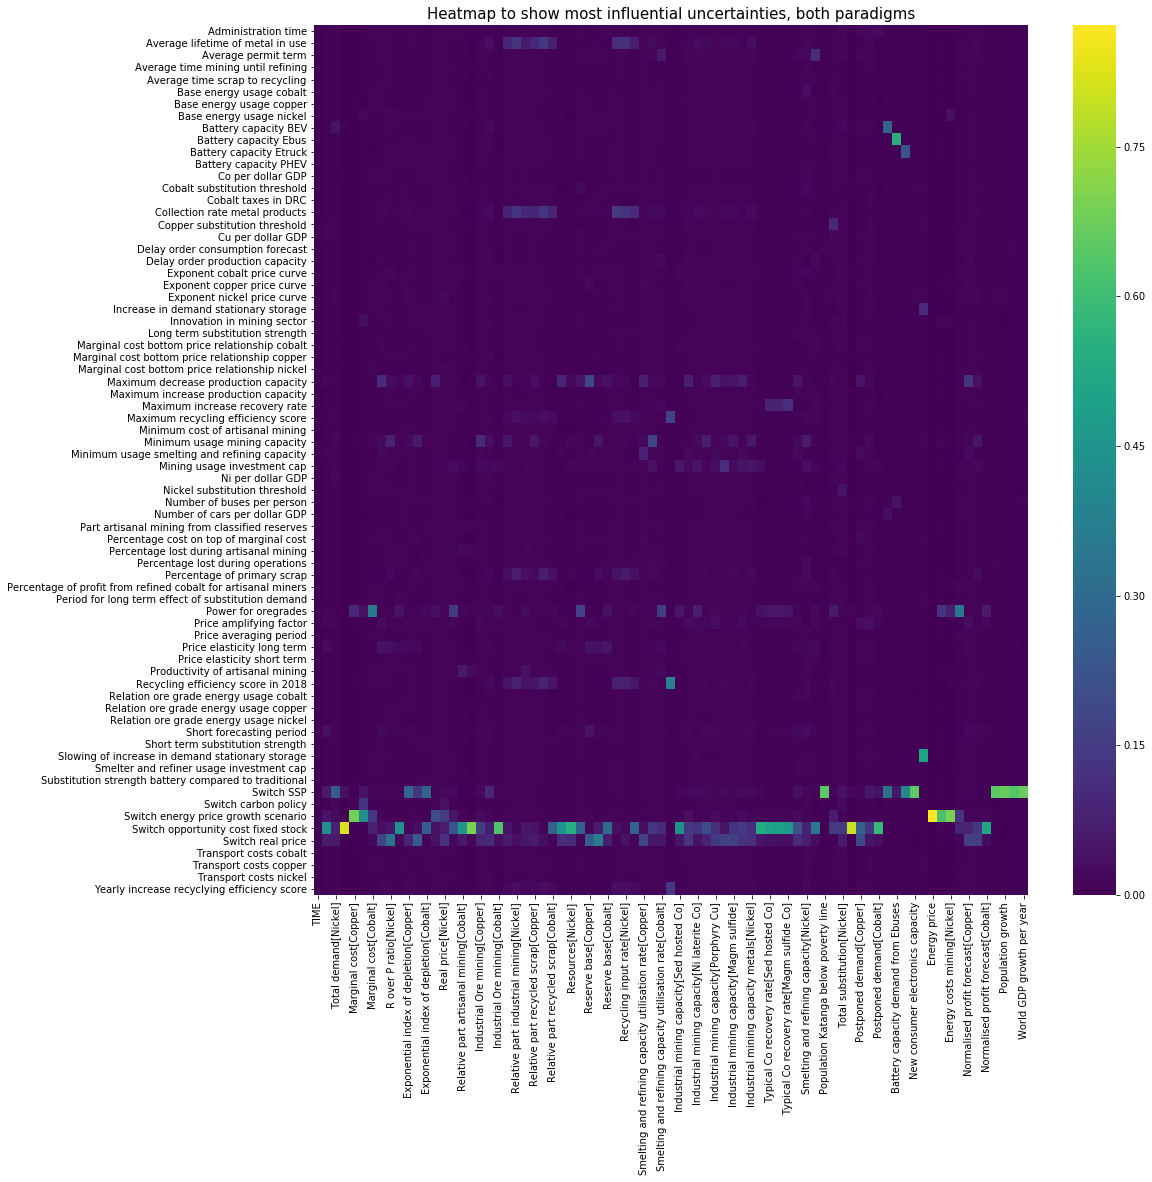

In [145]:
plt.figure(figsize = (16,16))
ax = sns.heatmap(feat_scoring_both, cmap = 'viridis', annot=False)
plt.title('Heatmap to show most influential uncertainties, both paradigms',fontsize=15)
plt.show()

### Heatmap when opportunity cost paradigm is 'switched on'

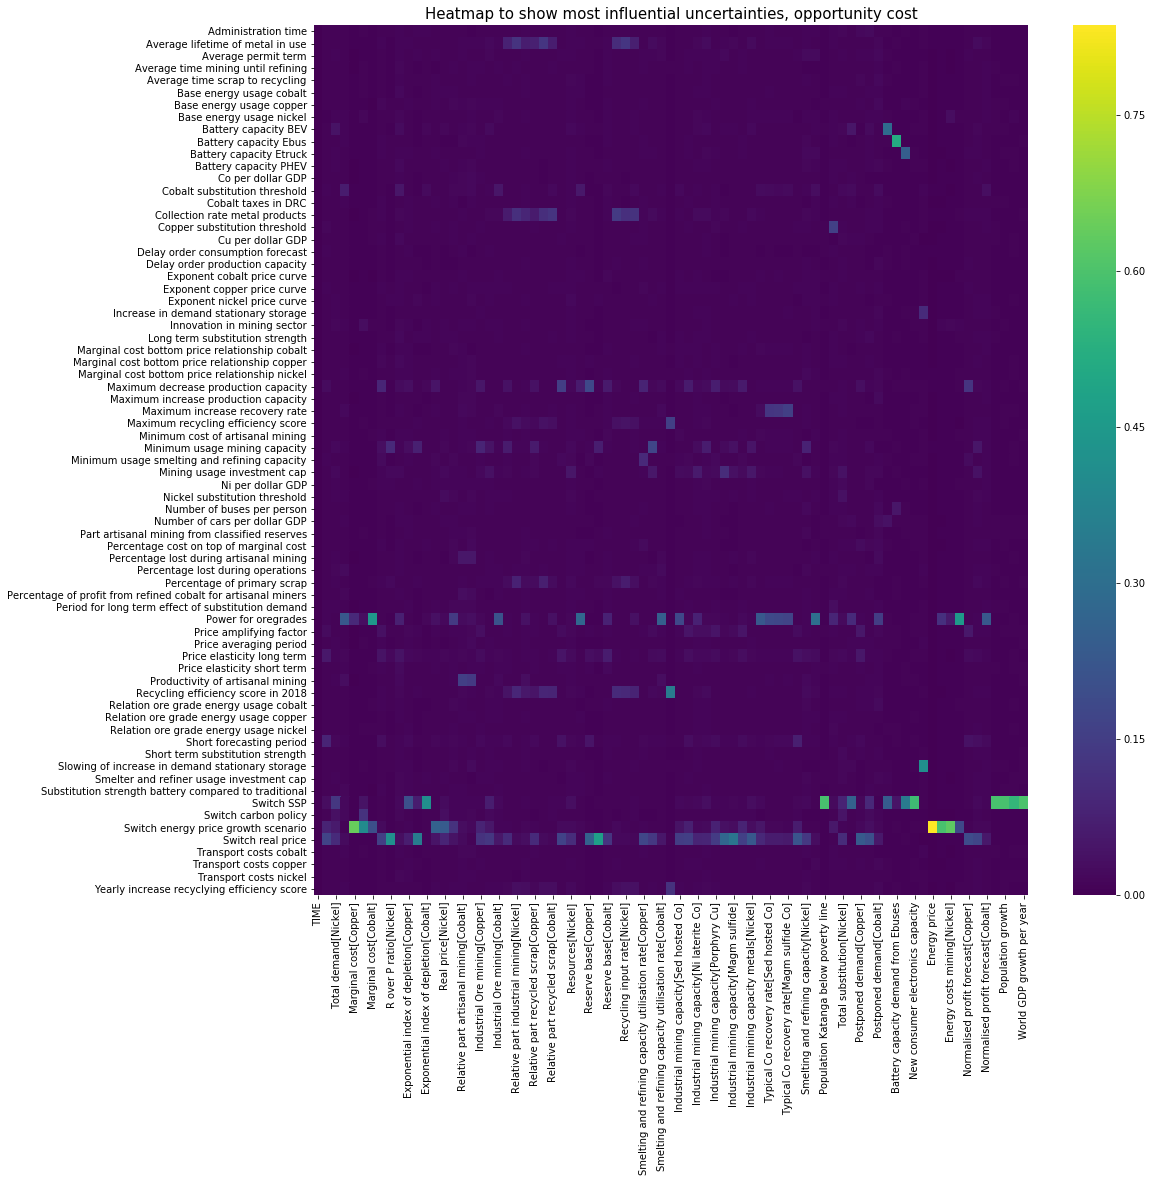

In [146]:
plt.figure(figsize = (16,16))
ax = sns.heatmap(feat_scoring_oc, cmap = 'viridis', annot=False)
plt.title('Heatmap to show most influential uncertainties, opportunity cost',fontsize=15)
plt.show()

### Heatmap when fixed stock paradigm is 'switched on'

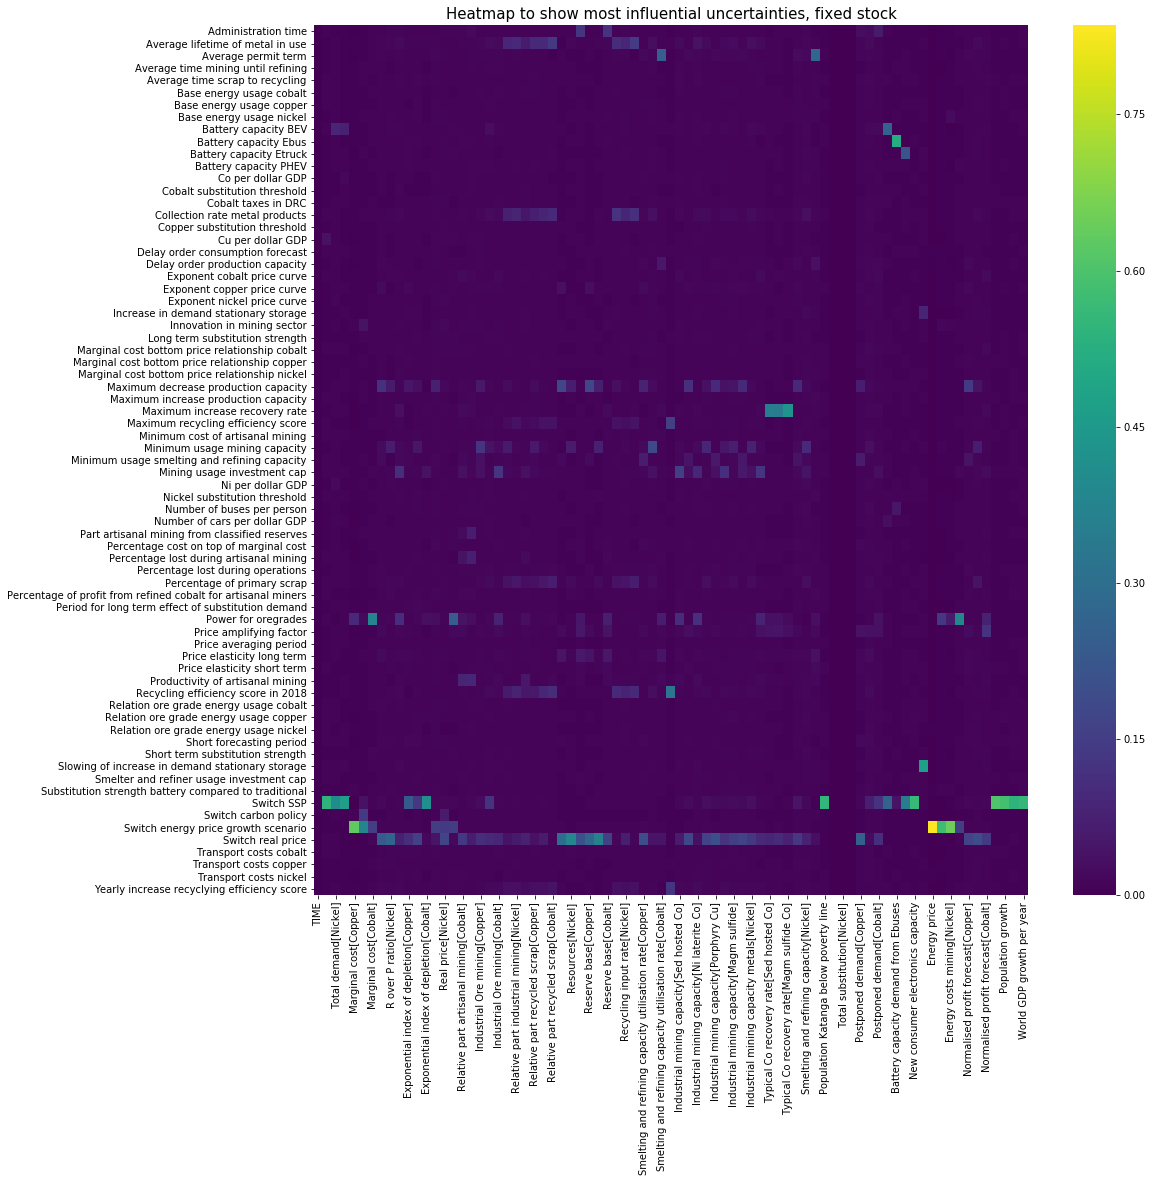

In [147]:
plt.figure(figsize = (16,16))
ax = sns.heatmap(feat_scoring_fs, cmap = 'viridis', annot=False)
plt.title('Heatmap to show most influential uncertainties, fixed stock',fontsize=15)
plt.show()